# Обучение сети c несколькими параметрами

Параметры обучения: Vgs, Vds, L, W, Temp

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras

import time

In [ ]:
from sklearn.metrics import mean_squared_error,r2_score 

In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

Загружаем свой датасет (простой)




In [ ]:
df = pd.read_csv('mosfet_simple.csv')

In [ ]:
# df = pd.read_csv('mosfet_complicated.csv')

In [ ]:
df.shape

(4563, 6)

In [ ]:
df.describe()

,Vds,Vgs,L,W,T,Id
count,4563.000000,4563.000000,4.563000e+03,4.563000e+03,4563.000000,4.563000e+03
mean,1.500000,1.500000,5.333333e-07,5.333333e-07,25.000000,1.432282e-04
std,0.935517,0.935517,3.399719e-07,3.399719e-07,20.414652,1.994167e-04
min,0.000000,0.000000,2.000000e-07,2.000000e-07,0.000000,-2.991882e-19
25%,0.750000,0.750000,2.000000e-07,2.000000e-07,0.000000,5.848275e-07
50%,1.500000,1.500000,4.000000e-07,4.000000e-07,25.000000,6.478563e-05
75%,2.250000,2.250000,1.000000e-06,1.000000e-06,50.000000,1.998776e-04
max,3.000000,3.000000,1.000000e-06,1.000000e-06,50.000000,1.132989e-03


In [ ]:
Id=df["Id"]
Vgs=df["Vgs"]
Vds=df["Vds"]
L=df["L"]
W=df["W"]
T=df["T"]


y=np.ravel(Id)
X=df.iloc[:,0:5]

In [ ]:
X.shape, y.shape

((4563, 5), (4563,))

In [ ]:
# Split train and test dataset
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Валидация

In [ ]:
def print_loss(y_val, y_pred):
  mse = tf.keras.metrics.mean_squared_error(y_val, y_pred)
  mae = tf.keras.metrics.mean_absolute_error(y_val, y_pred)
  mape = np.mean(tf.keras.metrics.mean_absolute_percentage_error(y_val, y_pred))
  r2 = r2_score(y_val, y_pred)

  loss = keras.losses.MSE(y_val, y_pred)

  print('MSE mean: ', np.mean(mse), '   MSE max: ', np.max(mse))
  print('MAE mean: ', np.mean(mae), '   MAE max: ', np.max(mae))
  print('MAPE: ', mape)
  print('R2: ', r2)

In [ ]:
def plot_predict(file_val, model, process_data=None, reprocess_data=None,
                 fun_x=lambda x: x, fun_y=lambda y: y, end=-1, 
                 print_val=True, color_pred=None, label_pred='Predicted',
                 title='Фактическое и прогнозируемое значение', 
                 xlabel='Напряжение на стоке (Vds)',
                 ylabel='Ток (Id)',
                 ):
  df = pd.read_csv(file_val)
  # Id=df["Id"]
  # yval=np.ravel(Id)
  # xval=df.iloc[:,0:5]

  if process_data != None:
    xval, yval = process_data(df)
  else:
    id=df["Id"]
    yval=np.ravel(id)
    xval=df.iloc[:,0:5]
  
  ypred = model.predict(xval)

  # print(ypred, yval, xval)

  if reprocess_data != None:
    ypred = reprocess_data(ypred)
    yval = reprocess_data(yval)

  print_loss(fun_y(yval[:end]), fun_y(ypred[:end]))

  vg=df["Vds"]
  
  if print_val:
    plt.plot(fun_x(vg)[:end], fun_y(yval)[:end], 'ro', label='Фактическое значение')

  if color_pred == None:
    plt.plot(fun_x(vg)[:end], fun_y(ypred)[:end], label=label_pred)
  else:
    plt.plot(fun_x(vg)[:end], fun_y(ypred)[:end], label=label_pred, color=color_pred)

  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.legend()


In [ ]:
def map_mosfet(file_val, model, process_data=None, reprocess_data=None):
  df = pd.read_csv(file_val)
  map = {}

  y=np.ravel(df["Id"])

  if process_data != None:
    xval, yval = process_data(df)
  else:
    yval=np.ravel(df["Id"])
    xval=df.iloc[:,0:5]
  
  ypred = model.predict(xval)
  if reprocess_data != None:
    ypred = reprocess_data(ypred)

  for i in range(len(df)):
    if map.get(f"{df.iloc[i]['W']} {df.iloc[i]['L']}", False) != False:
      map[f"{df.iloc[i]['W']} {df.iloc[i]['L']}"].append((ypred[i] - y[i])**2)
    else:
      map[f"{df.iloc[i]['W']} {df.iloc[i]['L']}"] = [(ypred[i] - y[i])**2]

  for key, values in map.items():
    map[key] = np.array(values).mean()

  return map

In [ ]:
def show_map(map_model, coef):

  x, y, sizes = [],[],[]
  for key, value in map_model.items():
    # print(map(float, key.split()))
    _x, _y = key.split()
    x.append(float(_x))
    y.append(float(_y))
    sizes.append(value)

  sizes = np.array(sizes)

  min_max = (sizes - sizes.min()) / sizes.max() * 1000

  plt.figure(figsize=(8, 8))
  plt.scatter(x, y, s=min_max, cmap='plasma', vmin=0, vmax=1000)
  for i in range(len(sizes)):
    plt.text(x[i], y[i], round(sizes[i] * coef, 2))
  plt.show()

# Предобработка

In [ ]:
class ProcessDataSimple(object):
  """Миксин создания модели подготовки данных"""
  def __init__(self, df, test_size=0.2, random_state=42):

    X, y = self._split_x_y(df)
    X_train, X_test, y_train, y_test = self._split_train_test(
        X, y, test_size=test_size, random_state=random_state
        )
    
    self.X_train = X_train
    self.X_test = X_test
    self.y_train = y_train
    self.y_test = y_test


  def _split_x_y(self, df):
    """разделение df на X и Y"""
    X = df.iloc[:,0:5]
    y = np.ravel(df["Id"])
    return X, y


  def _split_train_test(self, X, y, test_size, random_state):
    """разделение на train и test"""
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, 
                                                        random_state=random_state)
    return X_train, X_test, y_train, y_test


  def transform(self, df):
    """функция подготовки данных
        return: X и y"""
    return self._split_x_y(df)

  def retransform_y(self, y):
    """функция перевода,
     полученного Y в нормальный вид"""
    return y

In [ ]:
class ProcessDataLog(ProcessDataSimple):
  """Действуем на X функцией log10
      На Y функцией - 1 / log10"""

  REPLACE_ZERO_ID = 1e-20
  REPLACE_ZERO_VGS = 1e-3
  REPLACE_ZERO_VDS = 1e-3
  REPLACE_ZERO_T = 1e-3

  def __init__(self, df, test_size=0.2, random_state=42):
    data  = df.copy()
    self._replace_X(data)
    self._replace_y(data)

    self._log_x(data)
    self._log_y(data)

    X, y = self._split_x_y(data)

    X_train, X_test, y_train, y_test = self._split_train_test(
        X, y, test_size=test_size, random_state=random_state
        )
    
    self.X_train = X_train
    self.X_test = X_test
    self.y_train = y_train
    self.y_test = y_test

  def _replace_y(self, data):
    # замена отрицательных значений на нули
    data.loc[data["Id"] < 0, "Id"] = 0
    # Replace zeros
    data["Id"].replace({0:self.REPLACE_ZERO_ID}, inplace=True)

  def _replace_X(self, data):
    # Replace zeros
    data["Vgs"].replace({0:self.REPLACE_ZERO_VGS}, inplace=True)
    data["Vds"].replace({0:self.REPLACE_ZERO_VDS}, inplace=True)
    data["T"].replace({0:self.REPLACE_ZERO_T}, inplace=True)
  
  def _log_x(self, data):
    data.loc[:, 'Vds'] = data['Vds'].apply(np.log10)
    data.loc[:, 'Vgs'] = data['Vgs'].apply(np.log10)

  def _log_y(self, data):
    data.loc[:, 'Id'] = data['Id'].apply(lambda x: -1/np.log10(x))


  def transform(self, df):
    data = df.copy()
    self._replace_X(data)
    self._replace_y(data)

    self._log_x(data)
    self._log_y(data)

    X, y = self._split_x_y(data)
    return X, y

  def retransform_y(self, y):
    # y_new = (y - min) / (max - min)
    # return y * (self.scaler_y.data_max_ - self.scaler_y.data_min_) + self.scaler_y.data_min_
    return 10 ** (-1 / y)

In [ ]:
class ProcessDataGenerate(ProcessDataLog):
  """Действуем на данные функцией с LOG10 и нормализируем тестувую выборку"""

  def __init__(self, df, test_size=0.2, random_state=42):
    data = df.copy()
    self._replace_X(data)
    self._replace_y(data)

    self._log_x(data)
    self._log_y(data)

    X, y = self._split_x_y(data)
    X = self.generate(X)

    self.scaler_X, self.scaler_Y, X, y = self._scaler(X, y)

    X_train, X_test, y_train, y_test = self._split_train_test(
        X, y, test_size=test_size, random_state=random_state
        )
    
    self.data = data
    self.X_train = X_train
    self.X_test = X_test
    self.y_train = y_train
    self.y_test = y_test

  def generate(self, X):
    T = X['T'] + 273.15
    X = np.c_[X['Vgs'], X['Vds'], X['Vgs']**2, X['Vds']**2, X['Vgs'] * X['Vds'],
              X['Vgs']**2 * X['Vds'], X['Vgs'] * X['Vds']**2,

              1 / X['L'], 
              X['Vgs'] / X['L'], X['Vds'] / X['L'], X['Vgs']**2 / X['L'], X['Vds']**2 / X['L'], X['Vgs'] * X['Vds'] / X['L'],
              # X['Vgs']**2 * X['Vds'] / X['L'], X['Vgs'] * X['Vds']**2 / X['L'],

              1 / X['W'], 
              X['Vgs'] * X['W'], X['Vds'] * X['W'], X['Vgs']**2 * X['W'], X['Vds']**2 * X['W'], X['Vgs'] * X['Vds'] * X['W'],
              # X['Vgs']**2 * X['Vds'] * X['W'], X['Vgs'] * X['Vds']**2 * X['W'],

              1 / T, T,
              # X['Vgs'] * T, X['Vds'] * T, X['Vgs']**2 * T, X['Vds']**2 * T, X['Vgs'] * X['Vds'] * T,
              # X['Vgs']**2 * X['Vds'] * T, X['Vgs'] * X['Vds']**2 * T,
              ]
    # X = np.c_[X, X['L']]
    # X = np.c_[X, 1 / X['L'], X['Vgs'] / X['L'], X['Vds'] / X['L']]
    # X = np.c_[X, 1 / X['W'], X['Vgs'] * X['W'], X['Vds'] * X['W']]
    # X = np.c_[X, 1 / X['T'], X['Vgs'] / X['T'], X['Vds'] / X['T']]
    return X


  def _scaler(self, X, y):
    scaler_X = preprocessing.StandardScaler().fit(X)
    X = scaler_X.transform(X)

    y = y.reshape(-1, 1)
    scaler_Y = preprocessing.StandardScaler().fit(y)
    y = scaler_Y.transform(y)
    return scaler_X, scaler_Y, X, y


  def transform(self, df):
    data = df.copy()
    self._replace_X(data)
    self._replace_y(data)

    self._log_x(data)
    self._log_y(data)

    X, y = self._split_x_y(data)
    X = self.generate(X)
    return self.scaler_X.transform(X), self.scaler_Y.transform(y.reshape(-1, 1))

  def retransform_y(self, y_in):
    y = y_in.copy()
    y = y * self.scaler_Y.scale_ + self.scaler_Y.mean_
    return 10 ** (-1 / y)

In [ ]:
from sklearn import preprocessing

In [ ]:
df = pd.read_csv('mosfet_simple.csv')
data_generate = ProcessDataGenerate(df)
print(data_generate.X_train)

[[ 5.32275155e-01  4.08926518e-01 -2.83973145e-01 ...  1.90292983e-02
   1.25749588e+00 -1.22473671e+00]
 [ 6.30767139e-01  6.30767139e-01 -2.54868042e-01 ...  3.67990509e-01
  -1.18913003e+00  1.22475304e+00]
 [-5.46153398e-01  2.43781239e-01 -1.83366314e-01 ... -6.12343194e-02
  -6.83658503e-02 -1.63302580e-05]
 ...
 [ 4.74465593e-01  6.30767139e-01 -2.98071329e-01 ...  9.00184100e-02
   1.25749588e+00 -1.22473671e+00]
 [ 5.83987569e-01 -2.05947067e-01 -2.69490896e-01 ... -6.24645886e-02
  -1.18913003e+00  1.22475304e+00]
 [-2.05947067e-01 -2.05947067e-01 -2.98071329e-01 ...  5.69795240e-02
   1.25749588e+00 -1.22473671e+00]]


# Бустинг

### Sklearn

In [ ]:
### Загружаем библиотеки и данные
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.metrics import mean_squared_error,r2_score 

import warnings
warnings.filterwarnings('ignore')

In [ ]:
### Разбираемся с признаками
scl = StandardScaler()
scl.fit(X)
X_scaled = scl.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.20, random_state=42)

In [ ]:
### Прописываем параметры для нашей модели 
params = {'n_estimators':1000,
          'max_depth':300,
          'criterion':'mse',
          'loss': 'huber',
          'learning_rate':0.03,
          'min_samples_leaf':100,
          'min_samples_split':100,
          }


### Тренируем
gbr = GradientBoostingRegressor(**params)
gbr.fit(X_train,y_train)

GradientBoostingRegressor(criterion='mse', learning_rate=0.03, loss='huber',
                          max_depth=300, min_samples_leaf=100,
                          min_samples_split=100, n_estimators=1000)

In [ ]:
gbr_ = GradientBoostingRegressor(**params)
gbr_.fit(data_generate.X_train, data_generate.y_train)

GradientBoostingRegressor(criterion='mse', learning_rate=0.03, loss='huber',
                          max_depth=300, min_samples_leaf=100,
                          min_samples_split=100, n_estimators=1000)

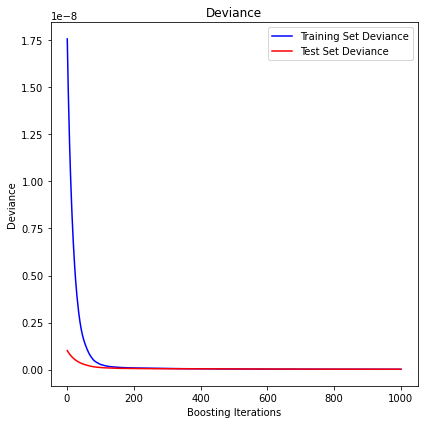

In [ ]:
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred in enumerate(gbr.staged_predict(X_test)):
    test_score[i] = gbr.loss_(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    gbr.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
fig.tight_layout()
plt.show()

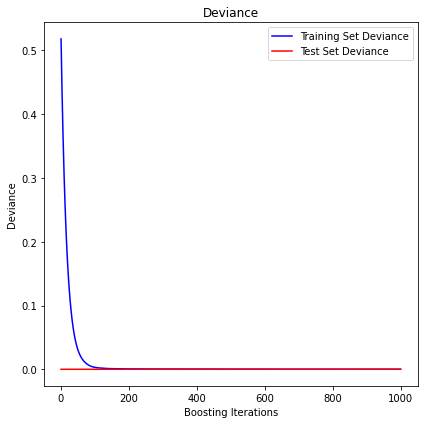

In [ ]:
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred in enumerate(gbr_.staged_predict(data_generate.X_test)):
    test_score[i] = gbr_.loss_(data_generate.retransform_y(data_generate.y_test), data_generate.retransform_y(y_pred))

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    gbr_.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
fig.tight_layout()
plt.show()

Найдем параметры которые наиболее влияют на результат

In [ ]:
from sklearn.inspection import permutation_importance

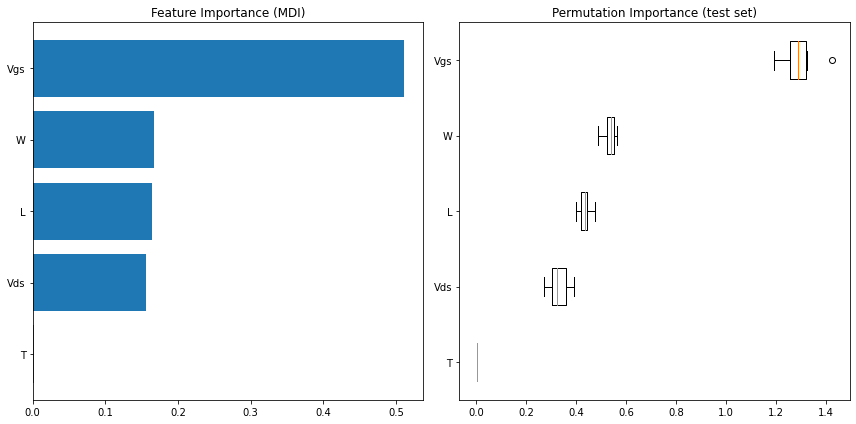

In [ ]:
feature_importance = gbr.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(['Vds', 'Vgs', 'L', 'W', 'T'])[sorted_idx])
plt.title("Feature Importance (MDI)")

result = permutation_importance(
    gbr, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(['Vds', 'Vgs', 'L', 'W', 'T'])[sorted_idx],
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

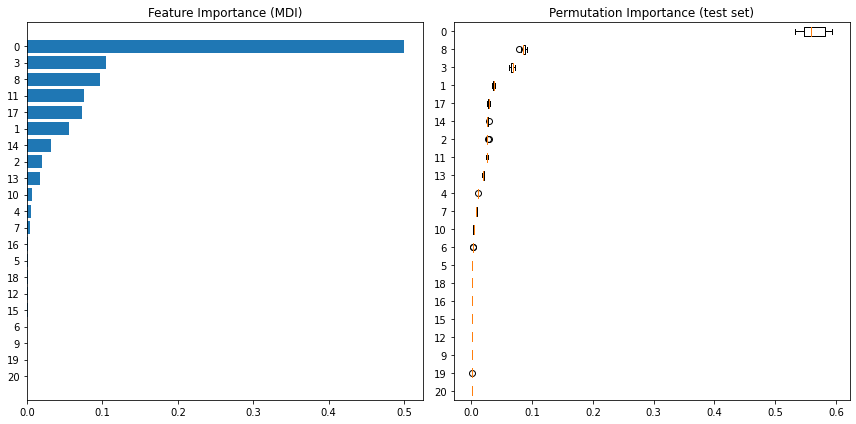

In [ ]:
feature_importance = gbr_.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array([i for i in range(21)])[sorted_idx])
plt.title("Feature Importance (MDI)")

result = permutation_importance(
    gbr_, data_generate.X_test, data_generate.y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array([i for i in range(21)])[sorted_idx],
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

In [ ]:
### Вычисляем точность
train_accuracy_score=gbr.score(X_train,y_train)
print(train_accuracy_score)

test_accuracy_score=gbr.score(X_test,y_test)
print(test_accuracy_score)

### Предсказание
y_pred = gbr.predict(X_test)

### И среднеквадратичную ошибку
print_loss(y_test,y_pred)

0.9963410818660202
0.9955189288524484
MSE mean:  1.8743888534683556e-10    MSE max:  1.8743888534683556e-10
MAE mean:  4.650164308193492e-06    MAE max:  4.650164308193492e-06
MAPE:  1036.7386496601084
R2:  0.9955189288524484


In [ ]:
### Вычисляем точность
train_accuracy_score=gbr_.score(data_generate.X_train, data_generate.y_train)
print(train_accuracy_score)

test_accuracy_score=gbr_.score(data_generate.X_test, data_generate.y_test)
print(test_accuracy_score)

### Предсказание
y_pred = gbr_.predict(data_generate.X_test)

### И среднеквадратичную ошибку
print_loss(y_test , data_generate.retransform_y(y_pred))

0.996099825793277
0.996391403310868
MSE mean:  2.1426478094569472e-11    MSE max:  2.1426478094569472e-11
MAE mean:  2.037544154148001e-06    MAE max:  2.037544154148001e-06
MAPE:  1.9244898124100178
R2:  0.9994877606500617


In [ ]:
def process_data(df):
  Id=df["Id"]
  yval=np.ravel(Id)
  xval=df.iloc[:,0:5]

  xval = scl.transform(xval)
  return xval, yval

MSE mean:  1.2284408543371033e-12    MSE max:  1.2284408543371033e-12
MAE mean:  7.519945182127605e-07    MAE max:  7.519945182127605e-07
MAPE:  143.20829385992963
R2:  0.07215509449911739
MSE mean:  1.9228283227639632e-12    MSE max:  1.0628575353688615e-11
MAE mean:  1.052274726129871e-06    MAE max:  3.237712568298688e-06
MAPE:  94.19690899823371
R2:  0.12039514235282045


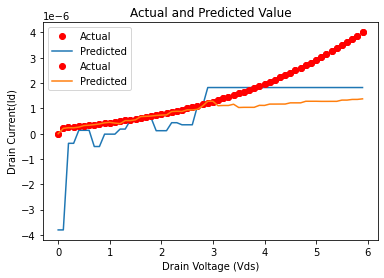

In [ ]:
plot_predict('mosfet_val_2.csv', gbr, process_data=process_data)
plot_predict('mosfet_val_2.csv', gbr_, process_data=data_generate.transform, reprocess_data=data_generate.retransform_y)

MSE mean:  1.260980319451145e-10    MSE max:  1.260980319451145e-10
MAE mean:  9.51666833778768e-06    MAE max:  9.51666833778768e-06
MAPE:  225.40940991392887
R2:  0.9187756259630546
MSE mean:  3.3357352609079646e-09    MSE max:  2.506015766249644e-08
MAE mean:  4.2634125950345285e-05    MAE max:  0.0001545976222766653
MAPE:  2562.910819622551
R2:  0.49656895345494856


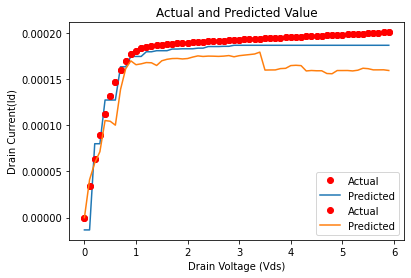

In [ ]:
plot_predict('mosfet_val_3.csv', gbr, process_data=process_data)
plot_predict('mosfet_val_3.csv', gbr_, process_data=data_generate.transform, reprocess_data=data_generate.retransform_y)

MSE mean:  5.062851528748893e-11    MSE max:  5.062851528748893e-11
MAE mean:  4.089519808377607e-06    MAE max:  4.089519808377607e-06
MAPE:  157.21664311422296
R2:  0.9665239981347086
MSE mean:  7.724620576378216e-09    MSE max:  1.860421444595373e-08
MAE mean:  7.345986094750181e-05    MAE max:  0.0001278060548732143
MAPE:  1619.4353611749193
R2:  -3.1595240873617296


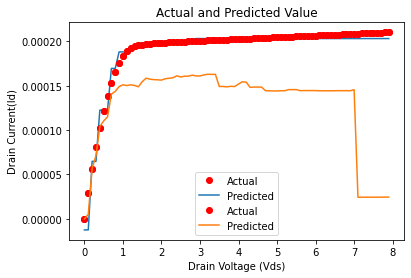

In [ ]:
plot_predict('mosfet_val_5.csv', gbr, process_data=process_data)
plot_predict('mosfet_val_5.csv', gbr_, process_data=data_generate.transform, reprocess_data=data_generate.retransform_y)

Посчитаем loss внутри области обучения

In [ ]:
df_val = pd.read_csv('data_val_in.csv')

id=df_val["Id"]
yval=np.ravel(id)
xval=df_val.iloc[:,0:5]
# print(xval)
y_pred = gbr.predict(xval)

print_loss(yval, y_pred)

MSE mean:  3.676776465824104e-08    MSE max:  3.676776465824104e-08
MAE mean:  0.00017378808775329313    MAE max:  0.00017378808775329313
MAPE:  29977.82626005776
R2:  -0.4097019932497299


Также посчитаем вне области обучения

In [ ]:
df_val = pd.read_csv('data_val_out.csv')
xval=df_val.iloc[:,0:5]
yval=np.ravel(df_val["Id"])
y_pred = gbr.predict(xval)

print_loss(yval, y_pred)

MSE mean:  2.929289952288053e-07    MSE max:  2.929289952288053e-07
MAE mean:  0.0003426396956053044    MAE max:  0.0003426396956053044
MAPE:  17817.774141717073
R2:  0.024258762722660587


### CatBoost

In [ ]:
!pip install catboost
!pip install scikit-learn
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

In [ ]:
# catboost для регрессии
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from matplotlib import pyplot
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostRegressor, Pool

In [ ]:
def process_data(df):
  Id=df["Id"]
  yval=np.ravel(Id)
  xval=df.iloc[:,0:5]

# применим преобразования что и при нормировке
  xval = scl.transform(xval)
  # yval = lbl.transform(yval)
  return xval, yval

In [ ]:
scl = StandardScaler()
scl.fit(X)
X_scaled = scl.transform(X)

In [ ]:
### Разбираемся с признаками

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.20, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
train_dataset = Pool(X_train, y_train)
train_dataset

In [ ]:
train_dataset_ = Pool(data_generate.X_train, data_generate.y_train)

In [ ]:
# Initialize CatBoostRegressor
model = CatBoostRegressor(iterations=40000,
                          use_best_model=True,
                          loss_function='RMSE',
                          eval_metric = 'MAPE',
                          task_type="GPU",
                          devices='0:1',
                          )

In [ ]:
# Fit model
model.fit(train_dataset,
          eval_set=(X_test, y_test),
          verbose=10000,
          # plot_file='catboost.png',
          )

Learning rate set to 0.02496
0:	learn: 0.0001413	test: 0.0001431	best: 0.0001431 (0)	total: 14.9ms	remaining: 9m 54s
10000:	learn: 0.0000026	test: 0.0000028	best: 0.0000028 (10000)	total: 1m 10s	remaining: 3m 31s
20000:	learn: 0.0000025	test: 0.0000026	best: 0.0000026 (19987)	total: 2m 16s	remaining: 2m 16s
30000:	learn: 0.0000023	test: 0.0000025	best: 0.0000025 (29925)	total: 3m 20s	remaining: 1m 6s
39999:	learn: 0.0000021	test: 0.0000023	best: 0.0000023 (39927)	total: 4m 13s	remaining: 0us
bestTest = 2.33625226e-06
bestIteration = 39927
Shrink model to first 39928 iterations.


In [ ]:
# Initialize CatBoostRegressor
model_ = CatBoostRegressor(iterations=40000,
                          use_best_model=True,
                          loss_function='RMSE',
                          eval_metric = 'MAPE',
                          task_type="GPU",
                          devices='0:1',
                          )

In [ ]:
# Fit model
model_.fit(train_dataset_,
          eval_set=(data_generate.X_test, data_generate.y_test),
          verbose=10000,
          # plot_file='catboost.png',
          )

Learning rate set to 0.02496
0:	learn: 0.6494757	test: 0.6440947	best: 0.6440947 (0)	total: 11.5ms	remaining: 7m 40s
10000:	learn: 0.0127273	test: 0.0135386	best: 0.0135386 (10000)	total: 1m 24s	remaining: 4m 14s
20000:	learn: 0.0112539	test: 0.0122180	best: 0.0122180 (20000)	total: 2m 38s	remaining: 2m 38s
30000:	learn: 0.0105741	test: 0.0116170	best: 0.0116170 (29999)	total: 3m 57s	remaining: 1m 19s
39999:	learn: 0.0099884	test: 0.0111143	best: 0.0111142 (39997)	total: 5m 3s	remaining: 0us
bestTest = 0.01111424374
bestIteration = 39997
Shrink model to first 39998 iterations.


In [ ]:
print(model.get_best_iteration())

39927


In [ ]:
print(model.get_best_score())

{'learn': {'MAPE': 2.07610390059752e-06, 'RMSE': 3.217782789455733e-06}, 'validation': {'MAPE': 2.3362522604105116e-06, 'RMSE': 3.770944253213405e-06}}


MSE mean:  2.8631988452668103e-13    MSE max:  2.8631988452668103e-13
MAE mean:  4.771851068514976e-07    MAE max:  4.771851068514976e-07
MAPE:  114.65311208635758
R2:  -1.715710291092598
MSE mean:  1.82746934996414e-13    MSE max:  5.068654025969471e-13
MAE mean:  3.4442726023263186e-07    MAE max:  6.557673279528202e-07
MAPE:  80.09916843170818
R2:  0.9608042786449983


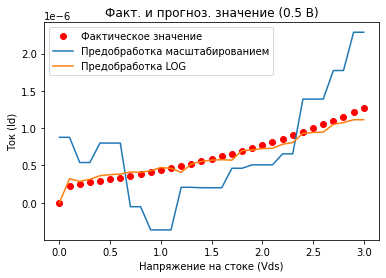

In [ ]:
plot_predict('mosfet_val_2.csv', model, process_data=process_data, end=-30,
             label_pred='Предобработка масштабированием',
             )
plot_predict('mosfet_val_2.csv', model_, 
             process_data=data_generate.transform, reprocess_data=data_generate.retransform_y, 
             end=-30,
             print_val=False,
             label_pred='Предобработка LOG',
             title='Факт. и прогноз. значение (0.5 В)'
             )

In [ ]:
_df = pd.read_csv('mosfet_val_3.csv')
_df

,Vds,Vgs,L,W,T,Id
0,0.0,2,5.000000e-07,5.000000e-07,25,1.844069e-31
1,0.1,2,5.000000e-07,5.000000e-07,25,3.370504e-05
2,0.2,2,5.000000e-07,5.000000e-07,25,6.348309e-05
3,0.3,2,5.000000e-07,5.000000e-07,25,8.953425e-05
4,0.4,2,5.000000e-07,5.000000e-07,25,1.120447e-04
...,...,...,...,...,...,...
56,5.6,2,5.000000e-07,5.000000e-07,25,1.998564e-04
57,5.7,2,5.000000e-07,5.000000e-07,25,2.001324e-04
58,5.8,2,5.000000e-07,5.000000e-07,25,2.004084e-04
59,5.9,2,5.000000e-07,5.000000e-07,25,2.006843e-04


MSE mean:  1.1599454012146503e-10    MSE max:  1.1599454012146503e-10
MAE mean:  9.487380211951112e-06    MAE max:  9.487380211951112e-06
MAPE:  138.45348053649735
R2:  0.9531364008287863
MSE mean:  4.6102532066137136e-09    MSE max:  2.609224236721213e-08
MAE mean:  4.588483159356645e-05    MAE max:  0.0001549768253212434
MAPE:  5036.6532614761345
R2:  0.9246598000486118


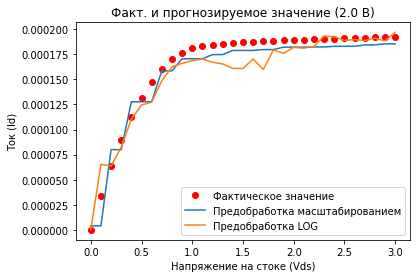

In [ ]:
plot_predict('mosfet_val_3.csv', model, process_data=process_data, end=-30,
             label_pred='Предобработка масштабированием',
             )
plot_predict('mosfet_val_3.csv', model_, 
             process_data=data_generate.transform, reprocess_data=data_generate.retransform_y, 
             end=-30,
             print_val=False,
             label_pred='Предобработка LOG',
             title='Факт. и прогнозируемое значение (2.0 В)'
             )

MSE mean:  1.1599454012146503e-10    MSE max:  1.1599454012146503e-10
MAE mean:  9.487380211951112e-06    MAE max:  9.487380211951112e-06
MAPE:  138.45348053649735
R2:  0.9531364008287863
MSE mean:  4.6102532066137136e-09    MSE max:  2.609224236721213e-08
MAE mean:  4.588483159356645e-05    MAE max:  0.0001549768253212434
MAPE:  5036.6532614761345
R2:  0.9246598000486118


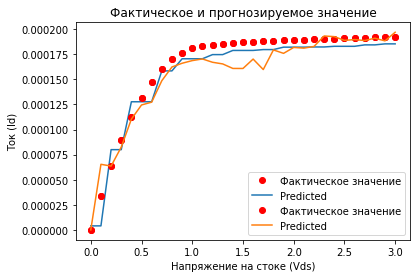

In [ ]:
plot_predict('mosfet_val_3.csv', model, process_data=process_data, end=-30)
plot_predict('mosfet_val_3.csv', model_, process_data=data_generate.transform, reprocess_data=data_generate.retransform_y, end=-30)

MSE mean:  4.12776607952753e-11    MSE max:  4.12776607952753e-11
MAE mean:  4.015346793403896e-06    MAE max:  4.015346793403896e-06
MAPE:  4.6588161333100135
R2:  0.9729560192586786
MSE mean:  5.258566811664413e-09    MSE max:  2.437134083648041e-08
MAE mean:  5.5406541821899024e-05    MAE max:  0.00014938787055686722
MAPE:  1901.1538728538912
R2:  -1.1322383801912301


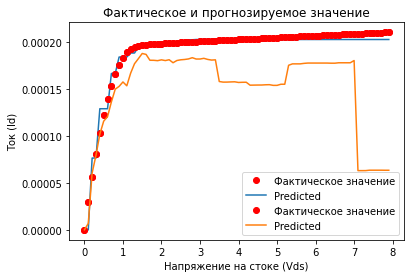

In [ ]:
plot_predict('mosfet_val_5.csv', model, process_data=process_data)
plot_predict('mosfet_val_5.csv', model_, process_data=data_generate.transform, reprocess_data=data_generate.retransform_y)

MSE mean:  1.2875422352922673e-10    MSE max:  1.2875422352922673e-10
MAE mean:  1.0519053580208674e-05    MAE max:  1.0519053580208674e-05
MAPE:  14.255878786279988
R2:  0.9019559566509701
MSE mean:  2.461054451020163e-09    MSE max:  2.9155745462039672e-08
MAE mean:  3.226314995378402e-05    MAE max:  0.00016785322451834866
MAPE:  322.0261948913799
R2:  0.7667808876347608


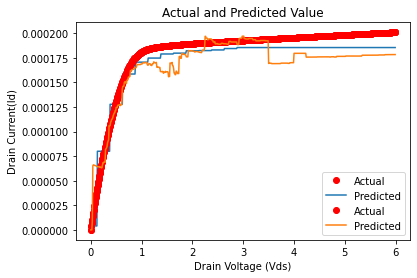

In [ ]:
plot_predict('mosfet_val_6.csv', model, process_data=process_data)
plot_predict('mosfet_val_6.csv', model_, process_data=data_generate.transform, reprocess_data=data_generate.retransform_y)

In [ ]:
df_val = pd.read_csv('data_val_in.csv')
# print(df_val)

id=df_val["Id"]
yval=np.ravel(id)
xval=df_val.iloc[:,0:5]
# print(xval)
y_pred = model.predict(xval)

print_loss(yval, y_pred)

MSE mean:  3.595158616511608e-08    MSE max:  3.595158616511608e-08
MAE mean:  0.00017186741881057487    MAE max:  0.00017186741881057487
MAPE:  29856.261520853714
R2:  -0.3784091349729095


In [ ]:
map_model = map_mosfet('data_val_in.csv', model, process_data=process_data)

In [ ]:
map_model_ = map_mosfet('data_val_in.csv', model_, process_data=data_generate.transform, reprocess_data=data_generate.retransform_y)

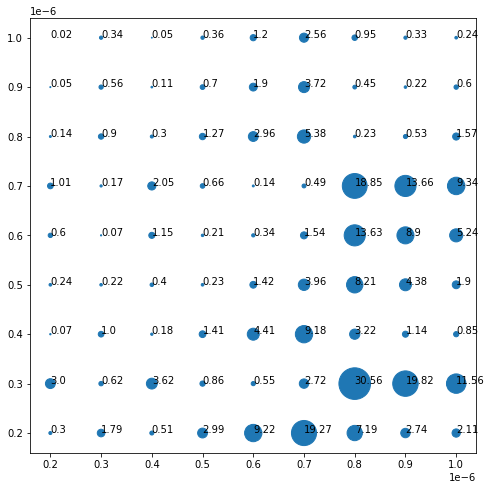

In [ ]:
show_map(map_model, 10e8)

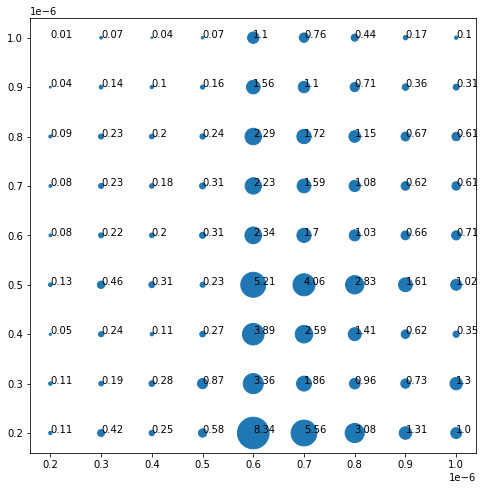

In [ ]:
show_map(map_model_, 10e8)

In [ ]:
xval, yval = data_generate.transform(df_val[:10000])
y_pred = model_.predict(xval)
del xval
print_loss(data_generate.retransform_y(yval), data_generate.retransform_y(y_pred))

MSE mean:  1.3327610923248373e-22    MSE max:  1.368634513017926e-21
MAE mean:  7.887108764144672e-12    MAE max:  3.597436218740755e-11
MAPE:  0.007887108764144671
R2:  -1.4186201238434992


In [ ]:
xval, yval = data_generate.transform(df_val[200_000:210_000])
y_pred = model_.predict(xval)
del xval
print_loss(data_generate.retransform_y(yval), data_generate.retransform_y(y_pred))

MSE mean:  4.299896520766016e-09    MSE max:  3.1116110734835566e-08
MAE mean:  5.15667396003351e-05    MAE max:  0.00017088047742650007
MAPE:  3202.74230986245
R2:  0.8423379225085595


In [ ]:
xval, yval = data_generate.transform(df_val[-20000:])
y_pred = model_.predict(xval)
del xval
print_loss(data_generate.retransform_y(yval), data_generate.retransform_y(y_pred))

MSE mean:  8.312873437330188e-08    MSE max:  6.471917052296844e-07
MAE mean:  0.00022705281024300175    MAE max:  0.0007771670070524367
MAPE:  13714.24186580847
R2:  0.9100328943651002


In [ ]:
df_val = pd.read_csv('data_val_out.csv')
# print(df_val)

id=df_val["Id"]
yval=np.ravel(id)
xval=df_val.iloc[:,0:5]
# print(xval)
y_pred = model.predict(xval)

print_loss(yval, y_pred)

MSE mean:  2.936756015606864e-07    MSE max:  2.936756015606864e-07
MAE mean:  0.0003426638280242622    MAE max:  0.0003426638280242622
MAPE:  17690.452597788393
R2:  0.021771830401537073


Переберем некоторые параметры и найдем более лучшие параметры

In [ ]:
model = CatBoostRegressor(
    task_type="CPU",
    devices='0:1',
)

params = {
            'iterations':[100, 500, 1000, 5000, 10000],
            'learning_rate': [1, 0.1, 0.05, 0.03, 0.01],
            'depth': [4, 6, 10, 12],
            'bootstrap_type':['Bayesian', 'No'],
}

grid_search_result = model.grid_search(params, X_scaled, y)

Выходные данные были обрезаны до нескольких последних строк (5000).
5004:	learn: 0.0000002	test: 0.0000007	best: 0.0000007 (5004)	total: 5.16s	remaining: 5.15s
5005:	learn: 0.0000002	test: 0.0000007	best: 0.0000007 (5005)	total: 5.16s	remaining: 5.15s
5006:	learn: 0.0000002	test: 0.0000007	best: 0.0000007 (5006)	total: 5.16s	remaining: 5.15s
5007:	learn: 0.0000002	test: 0.0000007	best: 0.0000007 (5007)	total: 5.17s	remaining: 5.15s
5008:	learn: 0.0000002	test: 0.0000007	best: 0.0000007 (5008)	total: 5.17s	remaining: 5.15s
5009:	learn: 0.0000002	test: 0.0000007	best: 0.0000007 (5009)	total: 5.17s	remaining: 5.15s
5010:	learn: 0.0000002	test: 0.0000007	best: 0.0000007 (5010)	total: 5.17s	remaining: 5.14s
5011:	learn: 0.0000002	test: 0.0000007	best: 0.0000007 (5011)	total: 5.17s	remaining: 5.14s
5012:	learn: 0.0000002	test: 0.0000007	best: 0.0000007 (5012)	total: 5.17s	remaining: 5.14s
5013:	learn: 0.0000002	test: 0.0000007	best: 0.0000007 (5013)	total: 5.17s	remaining: 5.14s
5014:	learn:

In [ ]:
print("\nBest Params : ", grid_search_result['params'])


Best Params :  {'depth': 6, 'iterations': 10000, 'learning_rate': 0.05, 'bootstrap_type': 'No'}


In [ ]:
print(model.get_best_score())

{'learn': {'RMSE': 1.0330331593119185e-07}}


In [ ]:
print("Best Score                : ",model.best_score_)
# print("List of Target Classses : ",model.classes_)
print("Data Feature Names      : ",model.feature_names_)
print("Feature Importance      : ", model.feature_importances_)
print("Learning Rate           : ",model.learning_rate_)
print("Random Seed             : ",model.random_seed_)
print("Number of Trees         : ",model.tree_count_)
print("Number of Features      : ",model.n_features_in_)

Best Score                :  {'learn': {'RMSE': 1.0330331593119185e-07}}
Data Feature Names      :  ['0', '1', '2', '3', '4']
Feature Importance      :  [17.76119307 33.64413667 18.88366054 29.48942614  0.22158359]
Learning Rate           :  0.05000000074505806
Random Seed             :  0
Number of Trees         :  10000
Number of Features      :  5


MSE mean:  5.395284377794552e-11    MSE max:  5.395284377794552e-11
MAE mean:  5.516951271742645e-06    MAE max:  5.516951271742645e-06
MAPE:  4.977613298843405
R2:  0.9643259240629045


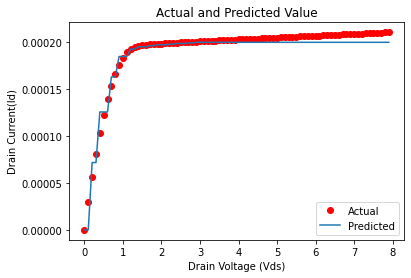

In [ ]:
plot_predict('mosfet_val_5.csv', model, process_data=process_data)

MSE mean:  9.397222783105273e-11    MSE max:  9.397222783105273e-11
MAE mean:  8.438218112486669e-06    MAE max:  8.438218112486669e-06
MAPE:  7.010392127740365
R2:  0.9283595718026397


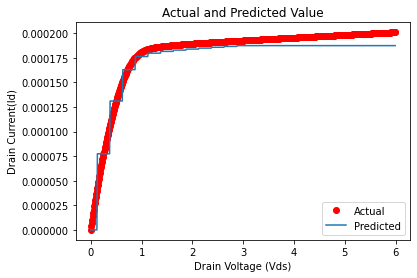

In [ ]:
plot_predict('mosfet_val_6.csv', model, process_data=process_data)

In [ ]:
df_val = pd.read_csv('data_val_in.csv')
# print(df_val)

id=df_val["Id"]
yval=np.ravel(id)
xval=df_val.iloc[:,0:5]
# print(xval)
y_pred = model.predict(xval)

print_loss(yval, y_pred)

MSE mean:  3.6439452407012855e-08    MSE max:  3.6439452407012855e-08
MAE mean:  0.00017293292499957804    MAE max:  0.00017293292499957804
MAPE:  29818.484176995044
R2:  -0.39711427030092894


In [ ]:
df_val = pd.read_csv('data_val_out.csv')
# print(df_val)

id=df_val["Id"]
yval=np.ravel(id)
xval=df_val.iloc[:,0:5]
# print(xval)
y_pred = model.predict(xval)

print_loss(yval, y_pred)

MSE mean:  2.9363370605226396e-07    MSE max:  2.9363370605226396e-07
MAE mean:  0.0003426445181201136    MAE max:  0.0003426445181201136
MAPE:  17684.297955018435
R2:  0.021911383589819255


# Lasso

In [ ]:
scl = StandardScaler()
scl.fit(X)
X_scaled = scl.transform(X_train)
X_scaled_test = scl.transform(X_test)

In [ ]:
def process_data(df):
  Id=df["Id"]
  yval=np.ravel(Id)
  xval=df.iloc[:,0:5]

# применим преобразования что и при нормировке
  xval = scl.transform(xval)
  # yval = lbl.transform(yval)
  return xval, yval

In [ ]:
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso

In [ ]:
model = LassoCV(cv=5, random_state=0, max_iter=10000)

In [ ]:
model = LassoCV()

In [ ]:
model.fit(X_scaled, y_train)

LassoCV()

In [ ]:
model.alpha_

1.2052664123230633e-07

In [ ]:
# Set best alpha
# lasso_best = Lasso(alpha=model.alpha_)
lasso_best = Lasso(alpha=0.4)
lasso_best.fit(X_scaled, y_train)

Lasso(alpha=0.4)

In [ ]:
print('R squared training set', round(lasso_best.score(X_scaled, y_train)*100, 2))
print('R squared test set', round(lasso_best.score(X_scaled_test, y_test)*100, 2))

R squared training set 0.0
R squared test set -0.01


In [ ]:
df_val = pd.read_csv('data_val_in.csv')

xval, yval = process_data(df_val)

y_pred = model.predict(xval)

print_loss(yval, y_pred)

MSE mean:  8.290216708042855e-09    MSE max:  8.290216708042855e-09
MAE mean:  6.702215081037646e-05    MAE max:  6.702215081037646e-05
MAPE:  16189.000200819473
R2:  0.6821472524525423


MSE mean:  2.9770643604441948e-08    MSE max:  2.9770643604441948e-08
MAE mean:  0.00015119536790777805    MAE max:  0.00015119536790777805
MAPE:  2177.831879038986
R2:  -18.684600963984803


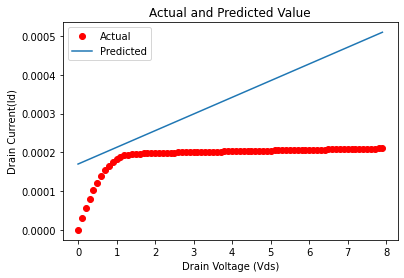

In [ ]:
plot_predict('mosfet_val_5.csv', model, process_data=process_data)

In [ ]:
from sklearn.linear_model import RidgeCV
model = RidgeCV()
model.fit(X_train, y_train)

In [ ]:
from sklearn.linear_model import ElasticNetCV
model = ElasticNetCV()
model.fit(X_train, y_train)

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [ ]:
  #Linear Equation of degree 2
poly_reg = PolynomialFeatures(degree=4)
X_poly = poly_reg.fit_transform(X_train)

In [ ]:
X_poly

array([[1.00000e+00, 1.75000e+00, 2.25000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [1.00000e+00, 2.75000e+00, 2.75000e+00, ..., 2.50000e-09,
        1.25000e-01, 6.25000e+06],
       [1.00000e+00, 1.25000e+00, 2.50000e-01, ..., 1.00000e-10,
        6.25000e-03, 3.90625e+05],
       ...,
       [1.00000e+00, 2.75000e+00, 2.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [1.00000e+00, 5.00000e-01, 2.50000e+00, ..., 1.00000e-10,
        2.50000e-02, 6.25000e+06],
       [1.00000e+00, 5.00000e-01, 5.00000e-01, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00]])

In [ ]:
lin_reg2 = LinearRegression()
lin_reg2.fit(X_poly,y_train)

LinearRegression()

In [ ]:
min_i = 0
min_mse = 100

for i in range(1, 20):
  poly_reg = PolynomialFeatures(degree=i)
  X_poly = poly_reg.fit_transform(X_train)
  lin_reg = LinearRegression()
  lin_reg.fit(X_poly,y_train)

  y_pred = lin_reg.predict(poly_reg.fit_transform(X_test))
  mse = tf.keras.metrics.mean_squared_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)
  print(i, float(mse), r2)
  # print_loss(y_test, y_pred)

  if min_mse > mse:
    min_mse = mse
    min_i = i

print(' === ', min_i, min_mse)

1 1.499231430086832e-08 0.6415811643121229
2 4.7919195012628335e-09 0.8854403547120685
3 3.5526829620459205e-09 0.9150665824321127
4 2.5285701376976034e-09 0.9395498822582568
5 2.545700629633731e-09 0.9391403463553074
6 4.7785539756641845e-09 0.8857598821730921
7 9.922141309696232e-09 0.7627929708259957
8 1.0025393252278238e-08 0.760324543317068
9 1.3834728043218464e-08 0.6692553919429509
10 3.492605107449833e-08 0.16502853995183375
11 7.80479916436955e-07 -17.658807260390965
12 1.6877565294905397e-08 0.5965107733970225
13 1.8505814717646075e-08 0.5575844775232515
14 1.7558594414326045e-08 0.5802295202726698
15 1.8311433733077353e-08 0.562231512315268
16 2.0239934166319376e-08 0.5161271640448919
17 2.05258726563832e-08 0.5092912787619179
18 2.023637919347713e-08 0.5162121522062559
19 2.0906530372476388e-08 0.5001909562460124
 ===  4 tf.Tensor(2.5285701376976034e-09, shape=(), dtype=float64)


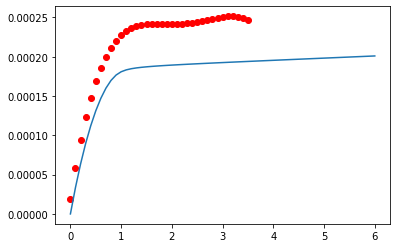

In [ ]:
df = pd.read_csv('mosfet_val_3.csv')
Id=df["Id"]
yval=np.ravel(Id)
xval=df.iloc[:,0:5]
vg=df["Vds"]

end = -25

# X_grid = np.arange(min(X),max(X),0.1)
# X_grid = X_grid.reshape(len(X_grid),1) 
y_poly = lin_reg2.predict(poly_reg.fit_transform(xval))

plt.scatter(vg[:end], y_poly[:end], color='red')
 
plt.plot(vg, yval)

In [ ]:
df_val = pd.read_csv('data_val_in.csv')
# print(df_val)

id=df_val["Id"]
yval=np.ravel(id)
xval=df_val.iloc[:,0:5]
# print(xval)
y_pred = lin_reg2.predict(poly_reg.fit_transform(xval))

print_loss(yval, y_pred)

MSE mean:  0.060067194910225975    MSE max:  0.060067194910225975
MAE mean:  0.17635204650693145    MAE max:  0.17635204650693145
MAPE:  35428548.2456908
R2:  -2303017.5593533576


# Нейронный сети

## Подготовка данных

Напишем модели подготовки данных

In [ ]:
# Split train and test dataset
from sklearn.model_selection import train_test_split

In [ ]:
class ProcessDataSimple(object):
  """Миксин создания модели подготовки данных"""
  def __init__(self, df, test_size=0.2, random_state=42):

    X, y = self._split_x_y(df)
    X_train, X_test, y_train, y_test = self._split_train_test(
        X, y, test_size=test_size, random_state=random_state
        )
    
    self.X_train = X_train
    self.X_test = X_test
    self.y_train = y_train
    self.y_test = y_test


  def _split_x_y(self, df):
    """разделение df на X и Y"""
    X = df.iloc[:,0:5]
    y = np.ravel(df["Id"])
    return X, y


  def _split_train_test(self, X, y, test_size, random_state):
    """разделение на train и test"""
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, 
                                                        random_state=random_state)
    return X_train, X_test, y_train, y_test


  def transform(self, df):
    """функция подготовки данных
        return: X и y"""
    return self._split_x_y(df)

  def retransform_y(self, y):
    """функция перевода,
     полученного Y в нормальный вид"""
    return y

In [ ]:
from sklearn import preprocessing

In [ ]:
# NEED CHANGE
class ProcessData(ProcessDataSimple):
  """Приводим данные к формату от 0 до 1"""
  def __init__(self, df, test_size=0.2, random_state=42):
    X, y = self._split_x_y(df)
    X, self.scaler_X = self._scaler(X)

    X_train, X_test, y_train, y_test = self._split_train_test(
        X, y, test_size=test_size, random_state=random_state,
        )
    
    self.X_train = X_train
    self.X_test = X_test
    self.y_train = y_train
    self.y_test = y_test


  def _scaler(self, X):
    """получение SCALER для X"""
    scaler = preprocessing.MinMaxScaler().fit(X)
    X_scaled = scaler.transform(X)
    return X_scaled, scaler


  def transform(self, df):
    X, y = self._split_x_y(df)
    return self.scaler_X.transform(X), y

  def retransform_y(self, y):
    return y

In [ ]:
class ProcessDataMinMax(ProcessDataSimple):
  """Действуем на данные MinMaxScaler"""

  def __init__(self, df, test_size=0.2, random_state=42):
    data = df.copy()

    X, y = self._split_x_y(df)

    self.scaler_X, self.scaler_Y = self._scaler(data)

    X_train, X_test, y_train, y_test = self._split_train_test(
        X, y, test_size=test_size, random_state=random_state
        )
    
    self.data = data
    self.X_train = X_train
    self.X_test = X_test
    self.y_train = y_train
    self.y_test = y_test


  def _scaler(self, data):
    scaler_X = preprocessing.MinMaxScaler().fit(data.iloc[:,0:5])
    data.iloc[:,0:5] = scaler_X.transform(data.iloc[:,0:5])

    y = data.loc[:, 'Id'].values.reshape(-1, 1)
    scaler_Y = preprocessing.MinMaxScaler().fit(y)
    data.loc[:, 'Id'] = scaler_Y.transform(y)
    return scaler_X, scaler_Y


  def transform(self, df):
    data = df.copy()

    X, y = self._split_x_y(data)
    return self.scaler_X.transform(X), self.scaler_Y.transform(y.reshape(-1, 1))

  def retransform_y(self, y):
    y = (self.scaler_Y.data_max_ - self.scaler_Y.data_min_) * y + self.scaler_Y.data_min_
    return y

In [ ]:
class ProcessDataStd(ProcessDataSimple):
  """Действуем на данные StandartScaler"""

  def __init__(self, df, test_size=0.2, random_state=42):
    data = df.copy()

    X, y = self._split_x_y(data)

    self.scaler_X, self.scaler_Y = self._scaler(data)

    X_train, X_test, y_train, y_test = self._split_train_test(
        X, y, test_size=test_size, random_state=random_state
        )
    
    self.data = data
    self.X_train = X_train
    self.X_test = X_test
    self.y_train = y_train
    self.y_test = y_test


  def _scaler(self, data):
    scaler_X = preprocessing.StandardScaler().fit(data.iloc[:,0:5])
    data.iloc[:,0:5] = scaler_X.transform(data.iloc[:,0:5])

    y = data.loc[:, 'Id'].values.reshape(-1, 1)
    scaler_Y = preprocessing.StandardScaler().fit(y)
    data.loc[:, 'Id'] = scaler_Y.transform(y)
    return scaler_X, scaler_Y


  def transform(self, df):
    data = df.copy()
    X, y = self._split_x_y(data)
    return self.scaler_X.transform(X), self.scaler_Y.transform(y.reshape(-1, 1))

  def retransform_y(self, y):
    y = y * self.scaler_Y.scale_ + self.scaler_Y.mean_
    return y

In [ ]:
# NEED CHANGE
class ProcessDataLog(ProcessDataSimple):
  """Действуем на X функцией log10
      На Y функцией - 1 / log10"""

  REPLACE_ZERO_ID = 1e-20
  REPLACE_ZERO_VGS = 1e-3
  REPLACE_ZERO_VDS = 1e-3
  REPLACE_ZERO_T = 1e-3

  def __init__(self, df, test_size=0.2, random_state=42):
    data  = df.copy()
    self._replace_X(data)
    self._replace_y(data)

    self._log_x(data)
    self._log_y(data)

    X, y = self._split_x_y(data)

    X_train, X_test, y_train, y_test = self._split_train_test(
        X, y, test_size=test_size, random_state=random_state
        )
    
    self.X_train = X_train
    self.X_test = X_test
    self.y_train = y_train
    self.y_test = y_test

  def _replace_y(self, data):
    # замена отрицательных значений на нули
    data.loc[data["Id"] < 0, "Id"] = 0
    # Replace zeros
    data["Id"].replace({0:self.REPLACE_ZERO_ID}, inplace=True)

  def _replace_X(self, data):
    # Replace zeros
    data["Vgs"].replace({0:self.REPLACE_ZERO_VGS}, inplace=True)
    data["Vds"].replace({0:self.REPLACE_ZERO_VDS}, inplace=True)
    data["T"].replace({0:self.REPLACE_ZERO_T}, inplace=True)
  
  def _log_x(self, data):
    data.loc[:, 'Vds'] = data['Vds'].apply(np.log10)
    data.loc[:, 'Vgs'] = data['Vgs'].apply(np.log10)

  def _log_y(self, data):
    data.loc[:, 'Id'] = data['Id'].apply(lambda x: -1/np.log10(x))


  def transform(self, df):
    data = df.copy()
    self._replace_X(data)
    self._replace_y(data)

    self._log_x(data)
    self._log_y(data)

    X, y = self._split_x_y(data)
    return X, y

  def retransform_y(self, y):
    # y_new = (y - min) / (max - min)
    # return y * (self.scaler_y.data_max_ - self.scaler_y.data_min_) + self.scaler_y.data_min_
    return 10 ** (-1 / y)

In [ ]:
class ProcessDataLogNorm(ProcessDataLog):
  """Действуем на данные функцией с LOG10 и нормализируем тестувую выборку"""

  def __init__(self, df, test_size=0.2, random_state=42):
    data = df.copy()
    self._replace_X(data)
    self._replace_y(data)

    self._log_x(data)
    self._log_y(data)

    X, y = self._split_x_y(data)

    self.scaler_X, self.scaler_Y = self._scaler(data)

    X_train, X_test, y_train, y_test = self._split_train_test(
        X, y, test_size=test_size, random_state=random_state
        )
    
    self.data = data
    self.X_train = X_train
    self.X_test = X_test
    self.y_train = y_train
    self.y_test = y_test


  def _scaler(self, data):
    scaler_X = preprocessing.StandardScaler().fit(data.iloc[:,0:5])
    data.iloc[:,0:5] = scaler_X.transform(data.iloc[:,0:5])

    y = data.loc[:, 'Id'].values.reshape(-1, 1)
    scaler_Y = preprocessing.StandardScaler().fit(y)
    data.loc[:, 'Id'] = scaler_Y.transform(y)
    return scaler_X, scaler_Y


  def transform(self, df):
    data = df.copy()
    self._replace_X(data)
    self._replace_y(data)

    self._log_x(data)
    self._log_y(data)

    X, y = self._split_x_y(data)
    return self.scaler_X.transform(X), self.scaler_Y.transform(y.reshape(-1, 1))

  def retransform_y(self, y_in):
    y = y_in.copy()
    y = y * self.scaler_Y.scale_ + self.scaler_Y.mean_
    return 10 ** (-1 / y)

In [ ]:
df = pd.read_csv('mosfet_simple.csv')
df.head()

,Vds,Vgs,L,W,T,Id
0,0.00,0.0,2.000000e-07,2.000000e-07,0.0,-1.205876e-28
1,0.25,0.0,2.000000e-07,2.000000e-07,0.0,6.993572e-13
2,0.50,0.0,2.000000e-07,2.000000e-07,0.0,1.252304e-12
3,0.75,0.0,2.000000e-07,2.000000e-07,0.0,1.814132e-12
4,1.00,0.0,2.000000e-07,2.000000e-07,0.0,2.387202e-12


In [ ]:
data_simple = ProcessDataSimple(df)
data_0 = ProcessData(df)
data_minmax = ProcessDataMinMax(df)
data_std = ProcessDataStd(df)
data_log = ProcessDataLog(df)
data_lognorm = ProcessDataLogNorm(df)

In [ ]:
# data.data.head()

In [ ]:
# data.data.describe()

In [ ]:
# print(data.y_train.mean(), data.y_train.std())
# data.y_train

In [ ]:
# data.retransform_y(data.transform(df)[1])

In [ ]:
def create_model():
  model = tf.keras.Sequential()

  model.add(keras.layers.Dense(30, activation='tanh', input_shape=(5,)))
  model.add(keras.layers.Dense(20, activation='tanh'))
  model.add(keras.layers.Dense(1, activation='sigmoid'))

  model.compile(optimizer='adam', loss='mape', metrics=['mse'])
  # model.summary()
  return model

In [ ]:
def fit_model(data):
  t1 = time.perf_counter()
  model = create_model()
  history = model.fit(data.X_train, data.y_train, epochs=1000, verbose=0, validation_data=(data.X_test, data.y_test))
  print('LAST loss: ', history.history['loss'][-1], 'val_loss: ', history.history['val_loss'][-1])
  print('TIME:',time.perf_counter()-t1)
  y_pred = model.predict(data.transform(df)[0])
  print_loss(df['Id'], data.retransform_y(y_pred))
  return model

In [ ]:
model_simple = fit_model(data_simple)

LAST loss:  43.55302810668945 val_loss:  42.8772087097168
TIME: 336.62185931199997
143/143 [==============================] - 0s 1ms/step
MAX loss:  6.027262e-08 mae:  0.00018245252
MEAN loss:  5.0750078e-08 mae:  0.00014244507
MAX value:  6.02726120371606e-08 mae: 0.00014322818808514193
MEAN value:  6.02726120371606e-08 mae: 0.00014322818808514193


In [ ]:
model_0 = fit_model(data_0)

LAST loss:  78.3597183227539 val_loss:  78.08810424804688
TIME: 382.38741075100006
143/143 [==============================] - 0s 1ms/step
MAX loss:  6.027262e-08 mae:  0.00014322819
MEAN loss:  6.027261e-08 mae:  0.0001432282
MAX value:  6.02726120371606e-08 mae: 0.00014322818808514193
MEAN value:  6.02726120371606e-08 mae: 0.00014322818808514193


In [ ]:
model_minmax = fit_model(data_minmax)

LAST loss:  43.160179138183594 val_loss:  44.82015609741211
TIME: 382.38826102100006
143/143 [==============================] - 0s 1ms/step
MAX loss:  1.0193853526193432e-06 mae:  0.0009897611097857584
MEAN loss:  3.1347736012717006e-07 mae:  0.00036817677087765284
MAX value:  6.02726120371606e-08 mae: 0.00014322818808514193
MEAN value:  6.02726120371606e-08 mae: 0.00014322818808514193


In [ ]:
model_std = fit_model(data_std)

LAST loss:  73.53347778320312 val_loss:  75.65169525146484
TIME: 334.5178691670003
143/143 [==============================] - 0s 1ms/step
MAX loss:  7.951652051711609e-08 mae:  0.00025746068723174763
MEAN loss:  4.70416399928847e-08 mae:  0.00016772817196851106
MAX value:  6.02726120371606e-08 mae: 0.00014322818808514193
MEAN value:  6.02726120371606e-08 mae: 0.00014322818808514193


In [ ]:
model_log = fit_model(data_log)

LAST loss:  6.332582473754883 val_loss:  6.019518852233887
TIME: 332.368132393
143/143 [==============================] - 0s 1ms/step
MAX loss:  1.03243536e-07 mae:  0.00029792762
MEAN loss:  5.4069897e-08 mae:  0.00016015688
MAX value:  6.02726120371606e-08 mae: 0.00014322818808514193
MEAN value:  6.02726120371606e-08 mae: 0.00014322818808514193


In [ ]:
model_lognorm = fit_model(data_lognorm)

LAST loss:  39.1427116394043 val_loss:  39.914756774902344
TIME: 382.37908827499996
143/143 [==============================] - 0s 1ms/step
MAX loss:  9.278038424728459e-08 mae:  0.0002808402537788802
MEAN loss:  5.6059328696205176e-08 mae:  0.00016401647918867863
MAX value:  6.02726120371606e-08 mae: 0.00014322818808514193
MEAN value:  6.02726120371606e-08 mae: 0.00014322818808514193


In [ ]:
def scheduler(epoch, lr):
  if epoch < 100:
    return 1.0
  elif 100 <= epoch < 600:
    return 0.03
  else:
    return 0.001

# def scheduler(epoch, lr):
#     decay_rate = 0.1
#     decay_step = 90
#     if epoch % decay_step == 0 and epoch:
#         return lr * decay_rate
#     return lr


model_call = create_model()
history_call = model_call.fit(data_lognorm.X_train, data_lognorm.y_train, 
                              epochs=1000, verbose=0, 
                              validation_data=(data_lognorm.X_test, data_lognorm.y_test), 
                              callbacks=[tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=0),
])

y_pred_call = model_call.predict(data_lognorm.transform(df)[0])
print_loss(df['Id'], data_lognorm.retransform_y(y_pred_call))

MAX loss:  5.5033626000926106e-08 mae:  0.00013608738197532535
MEAN loss:  5.503362600091045e-08 mae:  0.00013608738197530817
MAX value:  6.027261203716059e-08 mae: 0.00014322818808514193
MEAN value:  6.027261203716059e-08 mae: 0.00014322818808514193


In [ ]:
model_call.optimizer.lr.numpy()

0.001

Посмотрим на то на сколько хорошо предсказывает наша сеть

Параметры внутри области обучения

2/2 [==============================] - 0s 5ms/step
MAX loss:  2.0514492678924736e-08 mae:  0.00014322881232114136
MEAN loss:  1.3365191693350887e-09 mae:  2.692386494604189e-05
MAX value:  4.038496738042923e-08 mae: 0.0002009601139043
MEAN value:  3.3797255937217286e-08 mae: 0.0001795683449757238
2/2 [==============================] - 0s 3ms/step
MAX loss:  3.3797257e-08 mae:  0.00017956833
MEAN loss:  3.3483285e-09 mae:  3.272885e-05
MAX value:  3.3797255937217286e-08 mae: 0.00017956834497572384
MEAN value:  3.3797255937217286e-08 mae: 0.00017956834497572384
2/2 [==============================] - 0s 5ms/step
MAX loss:  3.8552577238566497e-10 mae:  1.963481022026098e-05
MEAN loss:  6.503404395943235e-11 mae:  7.243274809843038e-06
MAX value:  4.038496738042925e-08 mae: 0.0002009601139043
MEAN value:  3.3797255937217286e-08 mae: 0.00017956834497572384


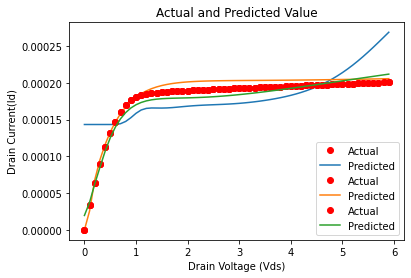

In [ ]:
# plot_predict('mosfet_val_3.csv', model_simple, process_data=data_simple.transform, reprocess_data=data_simple.retransform_y)
# plot_predict('mosfet_val_3.csv', model_0, process_data=data_0.transform, reprocess_data=data_0.retransform_y)
# plot_predict('mosfet_val_3.csv', model_minmax, process_data=data_minmax.transform, reprocess_data=data_minmax.retransform_y)
plot_predict('mosfet_val_3.csv', model_std, process_data=data_std.transform, reprocess_data=data_std.retransform_y)
plot_predict('mosfet_val_3.csv', model_log, process_data=data_log.transform, reprocess_data=data_log.retransform_y)
plot_predict('mosfet_val_3.csv', model_lognorm, process_data=data_lognorm.transform, reprocess_data=data_lognorm.retransform_y)
# plot_predict('mosfet_val_3.csv', model_call, process_data=data_lognorm.transform, reprocess_data=data_lognorm.retransform_y)
plt.legend()

Параметры вне области обучения

19/19 [==============================] - 0s 1ms/step
MAX loss:  2.0514492678924736e-08 mae:  0.00014322881232114136
MEAN loss:  1.1460988976279958e-09 mae:  2.5632709189837086e-05
MAX value:  4.038496738034885e-08 mae: 0.00020096011390410007
MEAN value:  3.400085626909417e-08 mae: 0.0001808013706695494
19/19 [==============================] - 0s 2ms/step
MAX loss:  3.400086e-08 mae:  0.00018080136
MEAN loss:  2.8808993e-09 mae:  3.060511e-05
MAX value:  3.4000856269094177e-08 mae: 0.00018080137066954938
MEAN value:  3.4000856269094177e-08 mae: 0.00018080137066954938
19/19 [==============================] - 0s 8ms/step
MAX loss:  3.8552577238566497e-10 mae:  1.963481022026098e-05
MEAN loss:  6.035643989978112e-11 mae:  7.064707450818912e-06
MAX value:  4.0384967380348876e-08 mae: 0.00020096011390410013
MEAN value:  3.400085626909417e-08 mae: 0.00018080137066954938


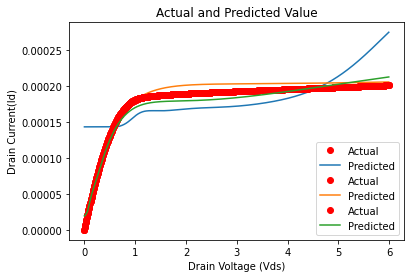

In [ ]:
# plot_predict('mosfet_val_3.csv', model_simple, process_data=data_simple.transform, reprocess_data=data_simple.retransform_y)
# plot_predict('mosfet_val_3.csv', model_0, process_data=data_0.transform, reprocess_data=data_0.retransform_y)
# plot_predict('mosfet_val_3.csv', model_minmax, process_data=data_minmax.transform, reprocess_data=data_minmax.retransform_y)
plot_predict('mosfet_val_6.csv', model_std, process_data=data_std.transform, reprocess_data=data_std.retransform_y)
plot_predict('mosfet_val_6.csv', model_log, process_data=data_log.transform, reprocess_data=data_log.retransform_y)
plot_predict('mosfet_val_6.csv', model_lognorm, process_data=data_lognorm.transform, reprocess_data=data_lognorm.retransform_y)
# plot_predict('mosfet_val_6.csv', model_call, process_data=data_lognorm.transform, reprocess_data=data_lognorm.retransform_y)
# plt.legend()

## Построение модели

**Import Tensorflow and Keras**

In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

Загрузим датасет

In [ ]:
df = pd.read_csv('mosfet_noise_5.csv')
# df = pd.read_csv('mosfet_simple.csv')

Выберем способ подготовки данных

Import hyperopt

In [ ]:
!pip install -U hyperopt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 34.6 MB/s 
     |████████████████████████████████| 200 kB 72.9 MB/s 
  Attempting uninstall: hyperopt
    Found existing installation: hyperopt 0.1.2
    Uninstalling hyperopt-0.1.2:
      Successfully uninstalled hyperopt-0.1.2


Будем использовать фреймворк Hyperopt для поиска оптимальных параметров нейросети. 

Сущеуствует различные способы находить оптимальные параметры:

1. Поиск по решётке
2. Случайный поиск.
3. Байесовская оптимизация

Давайте дадим примениние байесовской оптимизацией (с использованием Tree Parzen Estimator или TPE)

In [ ]:
import hyperopt

import warnings

warnings.filterwarnings("ignore")

print("Hyperopt Version : {}".format(hyperopt.__version__))

Hyperopt Version : 0.2.7


Установим Callbacks для обучающихся моделей

In [ ]:
# def scheduler(epoch, lr):
#   if epoch < 100:
#     return 1.0
#   elif 100 <= epoch < 600:
#     return 0.03
#   else:
#     return 0.001

In [ ]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=20, monitor='loss'),
    tf.keras.callbacks.TerminateOnNaN(),
    # keras.callbacks.LearningRateScheduler(schedule, verbose=0),
    # tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
    # tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]

Напишем функцию, которую необходимо будет оптимизировать

In [ ]:
data_std = ProcessDataStd(df)
data_log = ProcessDataLog(df)
data_lognorm = ProcessDataLogNorm(df)

process_data = {
    'data_std': data_std,
    'data_log': data_log,
    'data_lognorm': data_lognorm,
}

In [ ]:
from sklearn.metrics import mean_squared_error

def objective(args):
    model = tf.keras.Sequential()

    model.add(keras.layers.Dense(args['layers_1'], activation=args['activation_1'], input_shape=(5,)))
    model.add(keras.layers.Dense(args['layers_2'], activation=args['activation_2']))
    model.add(keras.layers.Dense(1, activation=args['activation_out']))

    model.compile(optimizer=args['optimizer'], loss=args['loss'], metrics=['mae'])

    data = process_data[args['process']]

    model.fit(data.X_train, data.y_train, epochs=1000, batch_size=256, shuffle=True, verbose=0, callbacks=my_callbacks)

    y_pred = model.predict(data.X_test)

    print("Hyperparameters : {}".format(args)) ## This can be commented if not needed.

    # ans = mean_squared_error(data.retransform_y(data.y_test), data.retransform_y(y_pred))

    try:
      # ans = mean_squared_error(data.retransform_y(data.y_test), data.retransform_y(y_pred))
      ans = np.mean(tf.keras.metrics.mean_absolute_percentage_error(data.retransform_y(data.y_test), data.retransform_y(y_pred)))
    except:
      ans = 1

    print("MSE : {}\n".format(ans))

    if ans == None:
      ans = 1

    return ans

Образуем область поиска

In [ ]:
from hyperopt import hp

In [ ]:
# data = ProcessDataLogNorm(df)

In [ ]:
search_space = {
    'layers_1': [5, 10, 15, 20, 25, 30, 35, 40],
    'layers_2': [5, 10, 15, 20, 25, 30, 35, 40],
    'activation_1': ['softmax', 'relu', 'tanh', 'sigmoid'],
    'activation_2': ['softmax', 'relu', 'tanh', 'sigmoid'],
    'activation_out': ['softmax', 'tanh', 'sigmoid'],
    'optimizer': ['Adam',],
    'loss': ['mse', 'mae', 'mape'],
    'process': ['data_log', 'data_lognorm']
}

In [ ]:
hp_search_space = {
    'layers_1': hp.choice('layers_1', search_space['layers_1']),
    'layers_2': hp.choice('layers_2', search_space['layers_2']),

    'activation_1': hp.choice('activation_1', search_space['activation_1']),
    'activation_2': hp.choice('activation_2', search_space['activation_2']),
    'activation_out': hp.choice('activation_out', search_space['activation_out']),

    'optimizer': hp.choice('optimizer', search_space['optimizer']),
    'loss': hp.choice('loss', search_space['loss']),
    'process': hp.choice('process', search_space['process']),
}

Начнем процесс оптимизации

In [ ]:
trials_obj = hyperopt.Trials()

t1 = time.perf_counter()

best_results = hyperopt.fmin(objective,
                             space=hp_search_space,
                             algo=hyperopt.tpe.suggest,
                             max_evals=100,
                             trials=trials_obj,
                            #  show_progressbar=True,
                            )

print('time taken to run:',time.perf_counter()-t1)

143/143 [==============================] - 0s 2ms/step

Hyperparameters : {'activation_1': 'sigmoid', 'activation_2': 'tanh', 'activation_out': 'tanh', 'layers_1': 40, 'layers_2': 10, 'loss': 'mape', 'optimizer': 'Adam', 'process': 'data_log'}
MSE : 33428.7578125

143/143 [==============================] - 0s 2ms/step

Hyperparameters : {'activation_1': 'softmax', 'activation_2': 'softmax', 'activation_out': 'softmax', 'layers_1': 30, 'layers_2': 20, 'loss': 'mse', 'optimizer': 'Adam', 'process': 'data_log'}
MSE : 23311314.0

143/143 [==============================] - 0s 2ms/step

Hyperparameters : {'activation_1': 'tanh', 'activation_2': 'relu', 'activation_out': 'tanh', 'layers_1': 10, 'layers_2': 5, 'loss': 'mape', 'optimizer': 'Adam', 'process': 'data_log'}
MSE : 25613.33984375

143/143 [==============================] - 0s 2ms/step

Hyperparameters : {'activation_1': 'tanh', 'activation_2': 'relu', 'activation_out': 'tanh', 'layers_1': 20, 'layers_2': 15, 'loss': 'mse', 'optimizer

In [ ]:
t1 = time.perf_counter()

best_results = hyperopt.fmin(objective,
                             space=hp_search_space,
                             algo=hyperopt.tpe.suggest,
                             max_evals=200,
                             trials=trials_obj,
                            #  show_progressbar=True,
                            )

print('time taken to run:',time.perf_counter()-t1)

29/29 [==============================] - 0s 2ms/step

Hyperparameters : {'activation_1': 'tanh', 'activation_2': 'tanh', 'activation_out': 'tanh', 'layers_1': 40, 'layers_2': 40, 'loss': 'mape', 'optimizer': 'Adam', 'process': 'data_log'}
MSE : 22734.177734375

29/29 [==============================] - 0s 2ms/step

Hyperparameters : {'activation_1': 'tanh', 'activation_2': 'tanh', 'activation_out': 'tanh', 'layers_1': 40, 'layers_2': 40, 'loss': 'mape', 'optimizer': 'Adam', 'process': 'data_log'}
MSE : 24761.267578125

29/29 [==============================] - 0s 2ms/step

Hyperparameters : {'activation_1': 'tanh', 'activation_2': 'tanh', 'activation_out': 'tanh', 'layers_1': 35, 'layers_2': 40, 'loss': 'mape', 'optimizer': 'Adam', 'process': 'data_log'}
MSE : 19521.572265625

29/29 [==============================] - 0s 2ms/step

Hyperparameters : {'activation_1': 'tanh', 'activation_2': 'tanh', 'activation_out': 'tanh', 'layers_1': 10, 'layers_2': 20, 'loss': 'mape', 'optimizer': 'Adam'

Лучший результат:

In [ ]:
print(best_results)

{'activation_1': 2, 'activation_2': 1, 'activation_out': 1, 'layers_1': 0, 'layers_2': 3, 'loss': 2, 'optimizer': 0, 'process': 1}


In [ ]:
def show_params(best_results):
  ans = {}
  for name, ind in best_results.items():
    ans[name] = search_space[name][ind]
  return ans

show_params(best_results)

{'activation_1': 'tanh',
 'activation_2': 'relu',
 'activation_out': 'tanh',
 'layers_1': 5,
 'layers_2': 20,
 'loss': 'mape',
 'optimizer': 'Adam',
 'process': 'data_log'}

In [ ]:
import json

# Save the trial results
with open('best_results.json', 'w') as f:
    f.write(json.dumps(show_params(best_results)))

In [ ]:
# Лучшие loss
# trials_obj_results = sorted(trials_obj.results, key = lambda x: x['loss'])
# trials_obj_results[:5]

In [ ]:
# Dataframe of results from optimization
tpe_results = pd.DataFrame({'val_loss': [x['loss'] for x in trials_obj.results], 
                            'iteration': trials_obj.idxs_vals[0]['layers_1'],
                            'activation_1': trials_obj.idxs_vals[1]['activation_1'],
                            'activation_2': trials_obj.idxs_vals[1]['activation_2'],
                            'activation_out': trials_obj.idxs_vals[1]['activation_out'],
                            'layers_1': trials_obj.idxs_vals[1]['layers_1'],
                            'layers_2': trials_obj.idxs_vals[1]['layers_2'],
                            'loss': trials_obj.idxs_vals[1]['loss'],
                            'optimizer': trials_obj.idxs_vals[1]['optimizer'],
                            'process': trials_obj.idxs_vals[1]['process'],
                            })
                            
tpe_results.head()

,val_loss,iteration,activation_1,activation_2,activation_out,layers_1,layers_2,loss,optimizer,process
0,4.314684e+04,0,1,2,2,7,5,2,0,0
1,2.648503e+04,1,1,3,1,2,2,1,0,1
2,2.156649e+04,2,1,2,1,6,2,2,0,1
3,2.346785e+07,3,1,0,0,2,0,1,0,1
4,2.346785e+07,4,1,3,0,5,2,0,0,1


In [ ]:
def _fun(name, lst):
  return [search_space[name][x] for x in lst]

tpe_results = pd.DataFrame({'val_loss': [x['loss'] for x in trials_obj.results], 
                            'iteration': trials_obj.idxs_vals[0]['layers_1'],
                            'activation_1': _fun('activation_1', trials_obj.idxs_vals[1]['activation_1']),
                            'activation_2': _fun('activation_2', trials_obj.idxs_vals[1]['activation_2']),
                            'activation_out': _fun('activation_out', trials_obj.idxs_vals[1]['activation_out']),
                            'layers_1': _fun('layers_1', trials_obj.idxs_vals[1]['layers_1']),
                            'layers_2': _fun('layers_2', trials_obj.idxs_vals[1]['layers_2']),
                            'loss': _fun('loss', trials_obj.idxs_vals[1]['loss']),
                            'optimizer': _fun('optimizer', trials_obj.idxs_vals[1]['optimizer']),
                            'process': _fun('process', trials_obj.idxs_vals[1]['process']),
                            })
                            
tpe_results.head()

,val_loss,iteration,activation_1,activation_2,activation_out,layers_1,layers_2,loss,optimizer,process
0,4.314684e+04,0,relu,tanh,sigmoid,40,30,mape,Adam,data_std
1,2.648503e+04,1,relu,sigmoid,tanh,15,15,mae,Adam,data_log
2,2.156649e+04,2,relu,tanh,tanh,35,15,mape,Adam,data_log
3,2.346785e+07,3,relu,softmax,softmax,15,5,mae,Adam,data_log
4,2.346785e+07,4,relu,sigmoid,softmax,30,15,mse,Adam,data_log


In [ ]:
tpe_results.to_csv('tpe_results.csv', index = False)

In [ ]:
top_results = tpe_results.sort_values(by='val_loss', ascending=True)[:10]
top_results

,val_loss,iteration,activation_1,activation_2,activation_out,layers_1,layers_2,loss,optimizer,process
85,9186.259766,85,tanh,relu,tanh,5,20,mape,Adam,data_log
156,9526.927734,156,tanh,tanh,tanh,5,20,mape,Adam,data_log
87,10011.259766,87,softmax,relu,sigmoid,5,20,mape,Adam,data_log
66,16809.013672,66,sigmoid,tanh,tanh,5,20,mape,Adam,data_log
44,18461.980469,44,tanh,tanh,tanh,40,40,mape,Adam,data_log
58,18555.355469,58,tanh,tanh,tanh,40,25,mape,Adam,data_log
192,19082.903387,192,sigmoid,tanh,tanh,5,20,mape,Adam,data_lognorm
144,19367.226018,144,tanh,tanh,tanh,5,30,mape,Adam,data_lognorm
152,19521.572266,152,tanh,tanh,tanh,35,40,mape,Adam,data_log
70,20141.808594,70,sigmoid,tanh,tanh,5,20,mape,Adam,data_log


In [ ]:
# print("Loss Value of Best Trial : {}".format(best_trial['result']['loss']))

Text(0.5, 1.0, 'activation')

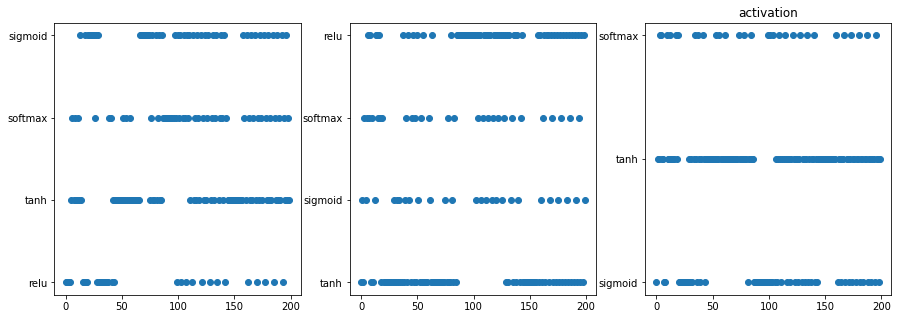

In [ ]:
fig, axs = plt.subplots(1, 3, figsize = (15, 5))
axs[0].scatter(tpe_results['iteration'], tpe_results['activation_1'])
axs[1].scatter(tpe_results['iteration'], tpe_results['activation_2'])
axs[2].scatter(tpe_results['iteration'], tpe_results['activation_out'])
plt.title('activation')

Text(0.5, 1.0, 'layers')

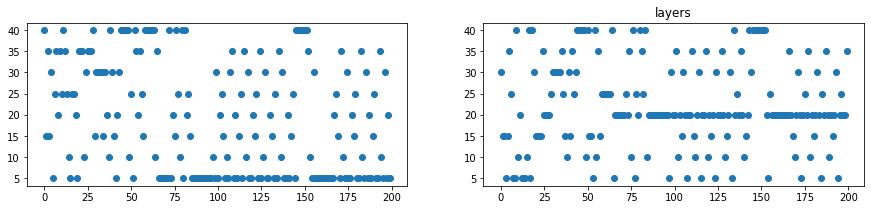

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (15, 3))
axs[0].scatter(tpe_results['iteration'], tpe_results['layers_1'])
axs[1].scatter(tpe_results['iteration'], tpe_results['layers_2'])
plt.title('layers')

Text(0.5, 1.0, 'Other')

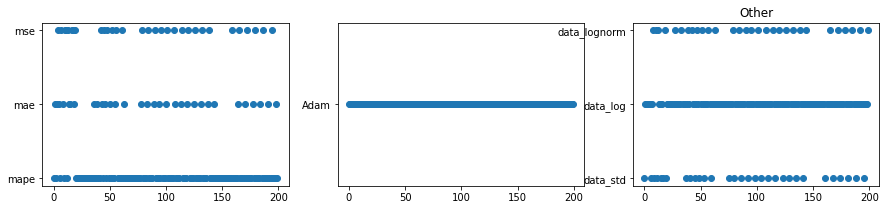

In [ ]:
fig, axs = plt.subplots(1, 3, figsize = (15, 3))
axs[0].scatter(tpe_results['iteration'], tpe_results['loss'])
axs[1].scatter(tpe_results['iteration'], tpe_results['optimizer'])
axs[2].scatter(tpe_results['iteration'], tpe_results['process'])
plt.title('Other')

Теперь давайте обучим несколько моделей нейросетей. Выберем лучшие из предложенных алгаритмом и несколько полученных ранее

In [ ]:
df = pd.read_csv('mosfet_noise_5.csv')

In [ ]:
data1 = ProcessDataLogNorm(df)
data = ProcessDataLog(df)

In [ ]:
top_results[:3]

,val_loss,iteration,activation_1,activation_2,activation_out,layers_1,layers_2,loss,optimizer,process
82,1.045662e-08,82,relu,softmax,tanh,25,30,mae,Adam,data_lognorm
72,1.046065e-08,72,relu,sigmoid,tanh,30,15,mae,Adam,data_lognorm
90,1.046205e-08,90,relu,softmax,tanh,25,30,mae,Adam,data_lognorm


Модель 1. Первое место

In [ ]:
model_1 = tf.keras.Sequential()

model_1.add(keras.layers.Dense(5, activation='tanh', input_shape=(5,)))
model_1.add(keras.layers.Dense(20, activation='relu'))
model_1.add(keras.layers.Dense(1, activation='tanh'))

model_1.compile(optimizer='adam', loss='mape', metrics=['mse'])
model_1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 5)                 30        
                                                                 
 dense_7 (Dense)             (None, 20)                120       
                                                                 
 dense_8 (Dense)             (None, 1)                 21        
                                                                 
Total params: 171
Trainable params: 171
Non-trainable params: 0
_________________________________________________________________


In [ ]:
t1 = time.perf_counter()

history_1 = model_1.fit(data.X_train, data.y_train, 
                      epochs=1000, 
                      validation_data=(data.X_test, data.y_test),
                      batch_size=256,
                      shuffle=True,
                      # validation_freq=2,
                      )

print('time taken to run:',time.perf_counter()-t1)

Epoch 1/1000
72/72 [==============================] - 1s 4ms/step - loss: 61.4168 - mse: 0.0181 - val_loss: 47.1139 - val_mse: 0.0098
Epoch 2/1000
72/72 [==============================] - 0s 3ms/step - loss: 42.6249 - mse: 0.0080 - val_loss: 40.0302 - val_mse: 0.0081
Epoch 3/1000
72/72 [==============================] - 0s 2ms/step - loss: 36.8864 - mse: 0.0062 - val_loss: 25.0872 - val_mse: 0.0032
Epoch 4/1000
72/72 [==============================] - 0s 3ms/step - loss: 23.2862 - mse: 0.0029 - val_loss: 20.2955 - val_mse: 0.0024
Epoch 5/1000
72/72 [==============================] - 0s 3ms/step - loss: 17.4209 - mse: 0.0020 - val_loss: 16.0435 - val_mse: 0.0016
Epoch 6/1000
72/72 [==============================] - 0s 3ms/step - loss: 14.3081 - mse: 0.0014 - val_loss: 14.4635 - val_mse: 0.0014
Epoch 7/1000
72/72 [==============================] - 0s 3ms/step - loss: 14.0927 - mse: 0.0013 - val_loss: 14.7002 - val_mse: 0.0013
Epoch 8/1000
72/72 [==============================] - 0s 3ms/s

Модель 2. Второе место

In [ ]:
top_results[:3]

,val_loss,iteration,activation_1,activation_2,activation_out,layers_1,layers_2,loss,optimizer,process
82,1.045662e-08,82,relu,softmax,tanh,25,30,mae,Adam,data_lognorm
72,1.046065e-08,72,relu,sigmoid,tanh,30,15,mae,Adam,data_lognorm
90,1.046205e-08,90,relu,softmax,tanh,25,30,mae,Adam,data_lognorm


In [ ]:
model_2 = tf.keras.Sequential()

model_2.add(keras.layers.Dense(5, activation='tanh', input_shape=(5,)))
model_2.add(keras.layers.Dense(20, activation='tanh'))
model_2.add(keras.layers.Dense(1, activation='tanh'))

model_2.compile(optimizer='adam', loss='mape', metrics=['mse'])
model_2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 5)                 30        
                                                                 
 dense_13 (Dense)            (None, 20)                120       
                                                                 
 dense_14 (Dense)            (None, 1)                 21        
                                                                 
Total params: 171
Trainable params: 171
Non-trainable params: 0
_________________________________________________________________


In [ ]:
t1 = time.perf_counter()

history_2 = model_2.fit(data.X_train, data.y_train, 
                      epochs=1000, 
                      validation_data=(data.X_test, data.y_test),
                      batch_size=256,
                      shuffle=True,
                      # validation_freq=2,
                      )

print('time taken to run:',time.perf_counter()-t1)

Epoch 1/1000
72/72 [==============================] - 1s 5ms/step - loss: 137.4370 - mse: 0.0824 - val_loss: 54.7442 - val_mse: 0.0081
Epoch 2/1000
72/72 [==============================] - 0s 3ms/step - loss: 40.5451 - mse: 0.0056 - val_loss: 35.4983 - val_mse: 0.0043
Epoch 3/1000
72/72 [==============================] - 0s 3ms/step - loss: 36.1492 - mse: 0.0045 - val_loss: 34.2989 - val_mse: 0.0044
Epoch 4/1000
72/72 [==============================] - 0s 3ms/step - loss: 35.1119 - mse: 0.0044 - val_loss: 33.6600 - val_mse: 0.0047
Epoch 5/1000
72/72 [==============================] - 0s 2ms/step - loss: 34.5621 - mse: 0.0045 - val_loss: 33.1072 - val_mse: 0.0041
Epoch 6/1000
72/72 [==============================] - 0s 2ms/step - loss: 34.1138 - mse: 0.0043 - val_loss: 32.9602 - val_mse: 0.0051
Epoch 7/1000
72/72 [==============================] - 0s 3ms/step - loss: 33.8401 - mse: 0.0045 - val_loss: 32.5963 - val_mse: 0.0038
Epoch 8/1000
72/72 [==============================] - 0s 3ms/

Модель 3. Просто какая-то модель

In [ ]:
# We'll use Keras to create a Neural network

# 5 - 32 - 16 - 1

model_3 = tf.keras.Sequential()

model_3.add(keras.layers.Dense(25, activation='relu', input_shape=(5,)))
model_3.add(keras.layers.Dense(30, activation='softmax'))
model_3.add(keras.layers.Dense(1, activation='tanh'))

model_3.compile(optimizer='adam', loss='mape', metrics=['mse'])
model_3.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 25)                150       
                                                                 
 dense_28 (Dense)            (None, 30)                780       
                                                                 
 dense_29 (Dense)            (None, 1)                 31        
                                                                 
Total params: 961
Trainable params: 961
Non-trainable params: 0
_________________________________________________________________


In [ ]:
t1 = time.perf_counter()

history_3 = model_3.fit(data1.X_train, data1.y_train, 
                      epochs=1000, 
                      validation_data=(data1.X_test, data1.y_test),
                      batch_size=256,
                      shuffle=True,
                      # validation_freq=2,
                      )

print('time taken to run:',time.perf_counter()-t1)

Epoch 1/1000
72/72 [==============================] - 1s 5ms/step - loss: 105.8611 - mse: 0.9891 - val_loss: 103.8481 - val_mse: 0.9760
Epoch 2/1000
72/72 [==============================] - 0s 3ms/step - loss: 105.7196 - mse: 0.9792 - val_loss: 102.1240 - val_mse: 0.9649
Epoch 3/1000
72/72 [==============================] - 0s 3ms/step - loss: 104.3126 - mse: 0.9662 - val_loss: 99.7651 - val_mse: 0.9547
Epoch 4/1000
72/72 [==============================] - 0s 3ms/step - loss: 102.3825 - mse: 0.9469 - val_loss: 100.1719 - val_mse: 0.9244
Epoch 5/1000
72/72 [==============================] - 0s 3ms/step - loss: 103.8321 - mse: 0.9072 - val_loss: 102.0594 - val_mse: 0.8826
Epoch 6/1000
72/72 [==============================] - 0s 3ms/step - loss: 100.3914 - mse: 0.8721 - val_loss: 98.7316 - val_mse: 0.8564
Epoch 7/1000
72/72 [==============================] - 0s 3ms/step - loss: 103.0800 - mse: 0.8518 - val_loss: 96.3701 - val_mse: 0.8463
Epoch 8/1000
72/72 [==============================]

Модель 4. Хорошая модель из прошлый ноутбуков

In [ ]:
# We'll use Keras to create a Neural network

# 5 - 32 - 16 - 1

model_4 = tf.keras.Sequential()

model_4.add(keras.layers.Dense(25, activation='relu', input_shape=(5,)))
model_4.add(keras.layers.Dense(30, activation='softmax'))
model_4.add(keras.layers.Dense(1, activation='tanh'))

model_4.compile(optimizer='adam', loss='mse', metrics=['mse'])
model_4.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 25)                150       
                                                                 
 dense_25 (Dense)            (None, 30)                780       
                                                                 
 dense_26 (Dense)            (None, 1)                 31        
                                                                 
Total params: 961
Trainable params: 961
Non-trainable params: 0
_________________________________________________________________


In [ ]:
t1 = time.perf_counter()

history_4 = model_4.fit(data1.X_train, data1.y_train, 
                      epochs=1000,
                      validation_data=(data1.X_test, data1.y_test),
                      batch_size=256,
                      shuffle=True,
                      # validation_freq=2,
                      )

print('time taken to run:',time.perf_counter()-t1)

Epoch 1/1000
72/72 [==============================] - 1s 5ms/step - loss: 0.9540 - mse: 0.9540 - val_loss: 0.8708 - val_mse: 0.8708
Epoch 2/1000
72/72 [==============================] - 0s 3ms/step - loss: 0.7729 - mse: 0.7729 - val_loss: 0.6684 - val_mse: 0.6684
Epoch 3/1000
72/72 [==============================] - 0s 3ms/step - loss: 0.5793 - mse: 0.5793 - val_loss: 0.4851 - val_mse: 0.4851
Epoch 4/1000
72/72 [==============================] - 0s 3ms/step - loss: 0.4063 - mse: 0.4063 - val_loss: 0.3367 - val_mse: 0.3367
Epoch 5/1000
72/72 [==============================] - 0s 3ms/step - loss: 0.3049 - mse: 0.3049 - val_loss: 0.2729 - val_mse: 0.2729
Epoch 6/1000
72/72 [==============================] - 0s 3ms/step - loss: 0.2611 - mse: 0.2611 - val_loss: 0.2438 - val_mse: 0.2438
Epoch 7/1000
72/72 [==============================] - 0s 3ms/step - loss: 0.2387 - mse: 0.2387 - val_loss: 0.2266 - val_mse: 0.2266
Epoch 8/1000
72/72 [==============================] - 0s 3ms/step - loss: 0.

Сохраним веса в виде файла

In [ ]:
model_1.save("model_1.h5") # save weights

In [ ]:
model_2.save("model_2.h5") # save weights

In [ ]:
model_3.save("model_3.h5") # save weights

In [ ]:
model_4.save("model_4.h5") # save weights

Загрузим веса из файла (по необходимости)

In [ ]:
model_1.load_weights("model_1.h5") # load weights

In [ ]:
model_2.load_weights("model_2.h5") # load weights

In [ ]:
model_3.load_weights("model_3.h5") # load weights

In [ ]:
model_4.load_weights("model_4.h5") # load weights

### **Построим графики loss моделей**

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def show_history(history, SKIP=10, title='Training and validation loss'):
  d = 5
  # Exclude the first few epochs so the graph is easier to read
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(loss) + 1)

  x = epochs[SKIP::5]

  plt.plot(x, loss[SKIP::5], 'g.', label='Training loss')
  plt.plot(x, val_loss[SKIP::5], 'b.', label='Validation loss')

  theta = np.polyfit(x, loss[SKIP::5], deg= d)
  model = np.poly1d(theta)
  plt.plot(x, model(x))

  theta = np.polyfit(x, val_loss[SKIP::5], deg= d)
  model = np.poly1d(theta)
  plt.plot(x, model(x))

  plt.title(title)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()  

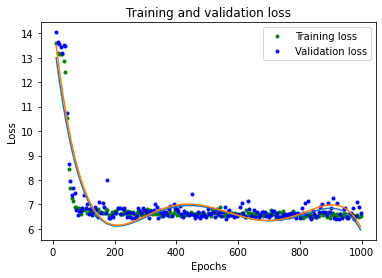

In [ ]:
show_history(history_1)

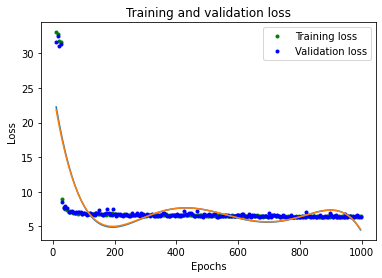

In [ ]:
show_history(history_2)

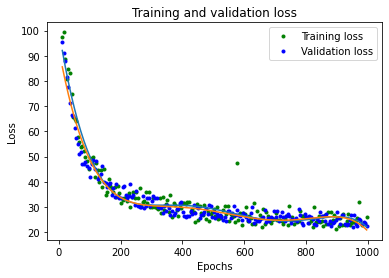

In [ ]:
show_history(history_3)

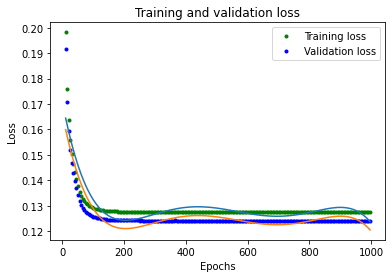

In [ ]:
show_history(history_4)

## Тестирование обученной сети

Применим новые данные, на которых сеть не обучалась. 

При этом не забудем про подготовку входных и выходных параметров. 

In [ ]:
# df1 = pd.read_csv('mosfet_val_3.csv') # проверка на работоспособность

In [ ]:
# xval, yval = data.transform(df1) # проверка на работоспособность

In [ ]:
# def show_val(xval, yval, df):
#   """Функция графиков валидационных кривых"""
#   vg1=df["Vds"] #change this index to vgs if you are going to plot Id-Vg
#   vg=np.ravel(vg1)
#   vg=vg.reshape(-1,1)
#   plt.plot(vg, 10**(-1/yval), 'ro', label='Actual')

#   plt.title('Actual and Predicted Value')
#   plt.xlabel('Drain Voltage (Vds)')
#   plt.ylabel('Drain Current(Id)')
#   plt.legend()

In [ ]:
# def show_pred(model, xval, df, name='', begin=0):
#   """Функция графиков предскасказаний сети"""
#   # Predict the new dataset
#   y_pred = model.predict(xval)
#   #plot the result
#   vg1=df["Vds"] #change this index to vgs if you are going to plot Id-Vg
#   vg=np.ravel(vg1)
#   vg=vg.reshape(-1,1)

#   plt.plot(vg[begin:], 10**(-1/y_pred)[begin:], label='Predicted ' + name)

Вспомним что область обучения лежала в пределах 0 до 3 В для напржений

In [ ]:
data = ProcessDataLog(df)
data1 = ProcessDataLogNorm(df)

2/2 [==============================] - 0s 6ms/step
MAX loss:  2.1053575e-19 mae:  4.4281454e-10
MEAN loss:  3.5354472e-20 mae:  1.3596047e-10
MAX value:  3.061276863014669e-20 mae: 1.2712881021117053e-10
MEAN value:  3.061276863014669e-20 mae: 1.2712881021117053e-10
2/2 [==============================] - 0s 6ms/step
MAX loss:  3.061277e-20 mae:  1.2712882e-10
MEAN loss:  2.2040203e-20 mae:  1.0064035e-10
MAX value:  3.061276863014669e-20 mae: 1.2712881021117053e-10
MEAN value:  3.061276863014669e-20 mae: 1.2712881021117053e-10


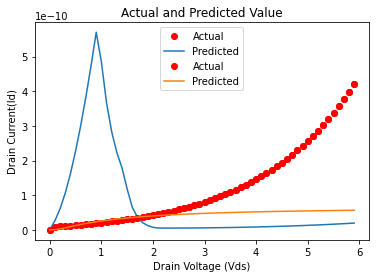

In [ ]:
plot_predict('mosfet_val_1.csv', model_1, process_data=data.transform, reprocess_data=data.retransform_y)
plot_predict('mosfet_val_1.csv', model_2, process_data=data.transform, reprocess_data=data.retransform_y)
# plot_predict('mosfet_val_1.csv', model_3, process_data=data1.transform, reprocess_data=data1.retransform_y)
# plot_predict('mosfet_val_1.csv', model_4, process_data=data1.transform, reprocess_data=data1.retransform_y)

2/2 [==============================] - 0s 5ms/step
MAX loss:  1.5751324e-11 mae:  3.7983352e-06
MEAN loss:  3.8264955e-12 mae:  1.5433704e-06
MAX value:  3.822655157297024e-12 mae: 1.5807222919465985e-06
MEAN value:  3.822655157297024e-12 mae: 1.5807222919465985e-06
2/2 [==============================] - 0s 5ms/step
MAX loss:  3.8226553e-12 mae:  1.5807223e-06
MEAN loss:  1.9415207e-12 mae:  1.0315581e-06
MAX value:  3.822655157297024e-12 mae: 1.5807222919465985e-06
MEAN value:  3.822655157297024e-12 mae: 1.5807222919465985e-06
2/2 [==============================] - 0s 7ms/step
MAX loss:  1.0870851464013951e-11 mae:  3.2970974301670175e-06
MEAN loss:  1.9330367644140165e-12 mae:  9.89092538328049e-07
MAX value:  1.718380208305797e-11 mae: 4.145334978389317e-06
MEAN value:  3.822655157297024e-12 mae: 1.5807222919465983e-06
2/2 [==============================] - 0s 7ms/step
MAX loss:  4.868634580267339e-12 mae:  2.206498262013215e-06
MEAN loss:  6.930457269054944e-13 mae:  5.163510626162

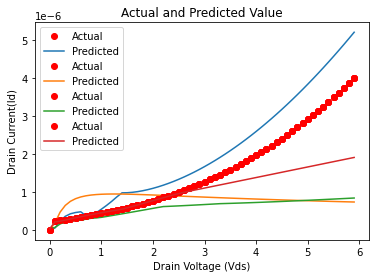

In [ ]:
plot_predict('mosfet_val_2.csv', model_1, process_data=data.transform, reprocess_data=data.retransform_y)
plot_predict('mosfet_val_2.csv', model_2, process_data=data.transform, reprocess_data=data.retransform_y)
plot_predict('mosfet_val_2.csv', model_3, process_data=data1.transform, reprocess_data=data1.retransform_y)
plot_predict('mosfet_val_2.csv', model_4, process_data=data1.transform, reprocess_data=data1.retransform_y)

2/2 [==============================] - 0s 9ms/step
MAX loss:  3.3797257e-08 mae:  0.00017956833
MEAN loss:  3.4944005e-09 mae:  3.975748e-05
MAX value:  3.3797255937217286e-08 mae: 0.00017956834497572384
MEAN value:  3.3797255937217286e-08 mae: 0.00017956834497572384
2/2 [==============================] - 0s 5ms/step
MAX loss:  3.3797257e-08 mae:  0.00017956833
MEAN loss:  4.6659516e-09 mae:  5.0547205e-05
MAX value:  3.3797255937217286e-08 mae: 0.00017956834497572384
MEAN value:  3.3797255937217286e-08 mae: 0.00017956834497572384
2/2 [==============================] - 0s 6ms/step
MAX loss:  2.34684829684818e-10 mae:  1.5319426545560313e-05
MEAN loss:  5.6189659495565817e-11 mae:  5.952275012245149e-06
MAX value:  4.038496738042925e-08 mae: 0.0002009601139043
MEAN value:  3.379725593721729e-08 mae: 0.00017956834497572384
2/2 [==============================] - 0s 17ms/step
MAX loss:  1.6803066173148402e-09 mae:  4.099154324143994e-05
MEAN loss:  7.090373716879038e-10 mae:  2.41161969668

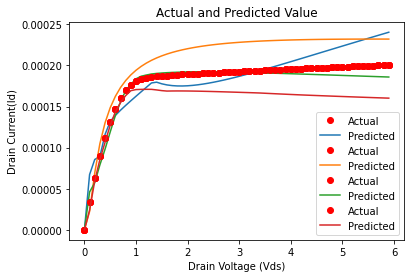

In [ ]:
plot_predict('mosfet_val_3.csv', model_1, process_data=data.transform, reprocess_data=data.retransform_y)
plot_predict('mosfet_val_3.csv', model_2, process_data=data.transform, reprocess_data=data.retransform_y)
plot_predict('mosfet_val_3.csv', model_3, process_data=data1.transform, reprocess_data=data1.retransform_y)
plot_predict('mosfet_val_3.csv', model_4, process_data=data1.transform, reprocess_data=data1.retransform_y)

2/2 [==============================] - 0s 5ms/step
MAX loss:  3.1843928e-07 mae:  0.00052602426
MEAN loss:  4.8491685e-08 mae:  0.00017474059
MAX value:  3.1843927403919354e-07 mae: 0.000526024216212575
MEAN value:  3.1843927403919354e-07 mae: 0.000526024216212575
2/2 [==============================] - 0s 9ms/step
MAX loss:  3.1843928e-07 mae:  0.00052602426
MEAN loss:  7.584006e-08 mae:  0.00024249454
MAX value:  3.1843927403919354e-07 mae: 0.000526024216212575
MEAN value:  3.1843927403919354e-07 mae: 0.000526024216212575
2/2 [==============================] - 0s 9ms/step
MAX loss:  1.2459430566393262e-07 mae:  0.00035297918587918553
MEAN loss:  6.927132523218342e-08 mae:  0.00022986710318206196
MAX value:  4.85150668431305e-07 mae: 0.0006965275790888002
MEAN value:  3.1843927403919354e-07 mae: 0.0005260242162125751
2/2 [==============================] - 0s 7ms/step
MAX loss:  1.0368504568164975e-07 mae:  0.0003220016237251759
MEAN loss:  5.449288829050292e-08 mae:  0.0001965070830967

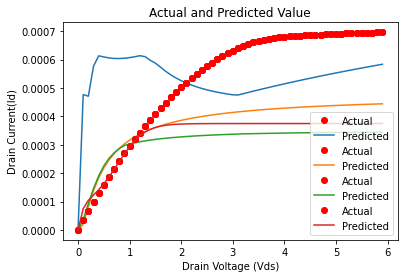

In [ ]:
plot_predict('mosfet_val_4.csv', model_1, process_data=data.transform, reprocess_data=data.retransform_y)
plot_predict('mosfet_val_4.csv', model_2, process_data=data.transform, reprocess_data=data.retransform_y)
plot_predict('mosfet_val_4.csv', model_3, process_data=data1.transform, reprocess_data=data1.retransform_y)
plot_predict('mosfet_val_4.csv', model_4, process_data=data1.transform, reprocess_data=data1.retransform_y)

3/3 [==============================] - 0s 3ms/step
MAX loss:  3.7838713e-08 mae:  0.00019059468
MEAN loss:  3.8523362e-09 mae:  4.5338413e-05
MAX value:  3.783871433050166e-08 mae: 0.00019059467976069889
MEAN value:  3.783871433050166e-08 mae: 0.00019059467976069889
3/3 [==============================] - 0s 4ms/step
MAX loss:  3.7838713e-08 mae:  0.00019059468
MEAN loss:  3.779607e-09 mae:  4.104027e-05
MAX value:  3.783871433050166e-08 mae: 0.00019059467976069889
MEAN value:  3.783871433050166e-08 mae: 0.00019059467976069889
3/3 [==============================] - 0s 3ms/step
MAX loss:  6.205505407031654e-09 mae:  7.877503035246418e-05
MEAN loss:  2.951331882298575e-09 mae:  5.2966012207622595e-05
MAX value:  4.427380185363794e-08 mae: 0.00021041340701970001
MEAN value:  3.783871433050166e-08 mae: 0.00019059467976069889
3/3 [==============================] - 0s 3ms/step
MAX loss:  1.0878354966552878e-09 mae:  3.2982351290580965e-05
MEAN loss:  1.201806434842521e-10 mae:  7.673703493458

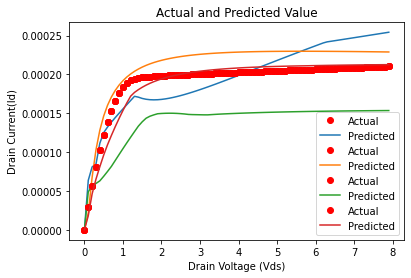

In [ ]:
plot_predict('mosfet_val_5.csv', model_1, process_data=data.transform, reprocess_data=data.retransform_y)
plot_predict('mosfet_val_5.csv', model_2, process_data=data.transform, reprocess_data=data.retransform_y)
plot_predict('mosfet_val_5.csv', model_3, process_data=data1.transform, reprocess_data=data1.retransform_y)
plot_predict('mosfet_val_5.csv', model_4, process_data=data1.transform, reprocess_data=data1.retransform_y)

19/19 [==============================] - 0s 1ms/step
MAX loss:  3.4000855e-08 mae:  0.00018080136
MEAN loss:  3.0115472e-09 mae:  3.7488484e-05
MAX value:  3.400085626909417e-08 mae: 0.00018080137066954938
MEAN value:  3.400085626909417e-08 mae: 0.00018080137066954938
19/19 [==============================] - 0s 1ms/step
MAX loss:  3.4000855e-08 mae:  0.00018080136
MEAN loss:  4.143856e-09 mae:  4.846247e-05
MAX value:  3.400085626909417e-08 mae: 0.00018080137066954938
MEAN value:  3.400085626909417e-08 mae: 0.00018080137066954938
19/19 [==============================] - 0s 1ms/step
MAX loss:  2.3468655135360614e-10 mae:  1.5319482737795233e-05
MEAN loss:  5.46250435563345e-11 mae:  5.8998636933667385e-06
MAX value:  4.0384967380348836e-08 mae: 0.00020096011390409994
MEAN value:  3.400085626909417e-08 mae: 0.0001808013706695494
19/19 [==============================] - 0s 2ms/step
MAX loss:  1.6803025088168758e-09 mae:  4.099149312743896e-05
MEAN loss:  7.078582406113567e-10 mae:  2.4238

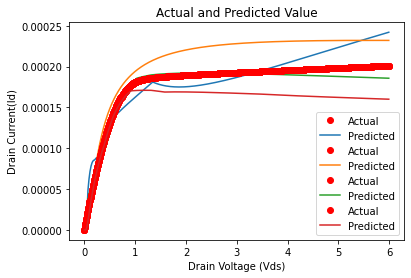

In [ ]:
plot_predict('mosfet_val_6.csv', model_1, process_data=data.transform, reprocess_data=data.retransform_y)
plot_predict('mosfet_val_6.csv', model_2, process_data=data.transform, reprocess_data=data.retransform_y)
plot_predict('mosfet_val_6.csv', model_3, process_data=data1.transform, reprocess_data=data1.retransform_y)
plot_predict('mosfet_val_6.csv', model_4, process_data=data1.transform, reprocess_data=data1.retransform_y)

Проверим теперь производные

In [ ]:
def show_pred_grad(df, model, pr='Vds', name='', begin=3):
  """Функция графика производной предсказания сети"""
  # Predict the new dataset
  xval, yval = data.transform(df1)
  y_pred = model.predict(xval)
  y_pred = data.retransform_y(y_pred)
  y_pred = y_pred.reshape(-1)

  vg1=df[pr] #change this index to vgs if you are going to plot Id-Vg

  plt.plot(vg1[begin:], np.gradient(y_pred)[begin:], label='Predicted ' + name)

2/2 [==============================] - 0s 6ms/step


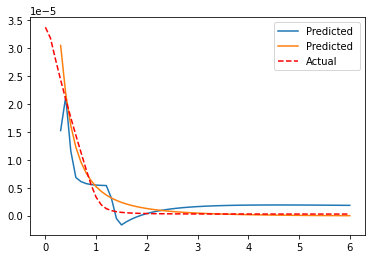

In [ ]:
df1 = pd.read_csv('mosfet_val_3.csv')
show_pred_grad(df1, model_1)
show_pred_grad(df1, model_2)
# show_pred_grad(df1, model_3)
# show_pred_grad(df1, model_4)
plt.plot(df1['Vds'], np.gradient(df1['Id']), 'r--', label='Actual')
plt.legend()

2/2 [==============================] - 0s 10ms/step


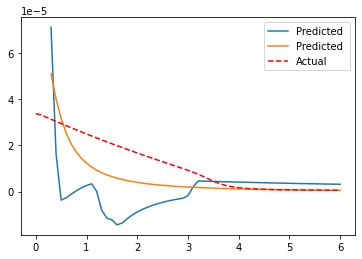

In [ ]:
df1 = pd.read_csv('mosfet_val_4.csv')
show_pred_grad(df1, model_1)
show_pred_grad(df1, model_2)
# show_pred_grad(df1, model_3)
# show_pred_grad(df1, model_4)
plt.plot(df1['Vds'], np.gradient(df1['Id']), 'r--', label='Actual')
plt.legend()

19/19 [==============================] - 0s 1ms/step


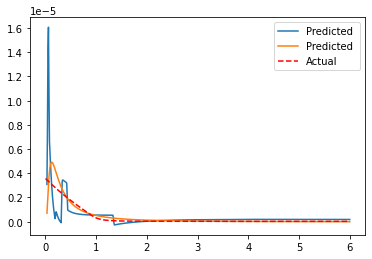

In [ ]:
df1 = pd.read_csv('mosfet_val_6.csv')
show_pred_grad(df1, model_1)
show_pred_grad(df1, model_2)
# show_pred_grad(df1, model_3)
# show_pred_grad(df1, model_4)
plt.plot(df1['Vds'], np.gradient(df1['Id']), 'r--', label='Actual')
plt.legend()

Теперь тут производная по V_gs

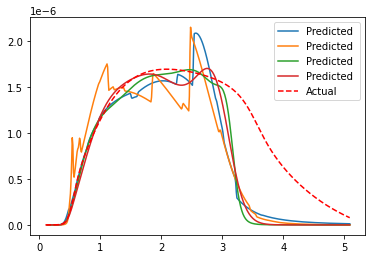

In [ ]:
df1 = pd.read_csv('mosfet_val_9.csv')
show_pred_grad(df1, model_1, pr='Vgs')
show_pred_grad(df1, model_2, pr='Vgs')
show_pred_grad(df1, model_3, pr='Vgs')
show_pred_grad(df1, model_4, pr='Vgs')
plt.plot(df1['Vgs'], np.gradient(df1['Id']), 'r--', label='Actual')
plt.legend()

Значние ранее

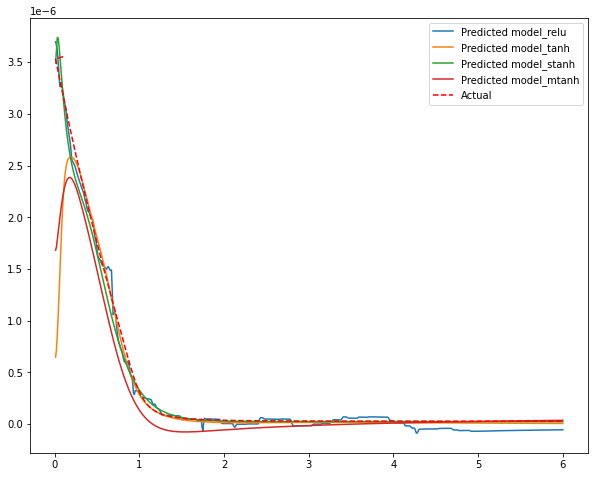

In [ ]:
df1 = pd.read_csv('mosfet_val_6.csv')
# xval, yval, df_ = process_data(df1)

fig, ax = plt.subplots(figsize=(10, 8))

show_pred_grad(model_relu, xval, df1, 'Vds',  'model_relu')
show_pred_grad(model_tanh, xval, df1, 'Vds', 'model_tanh')
# show_pred_grad(model_srelu, xval, df1, 'Vds', 'model_srelu')
show_pred_grad(model_stanh, xval, df1, 'Vds', 'model_stanh')
show_pred_grad(model_mtanh, xval, df1, 'Vds', 'model_mtanh')
# show_val_grad(xval, yval, df1)
plt.plot(df1['Vds'], np.gradient(df1['Id']), 'r--', label='Actual')
plt.legend()

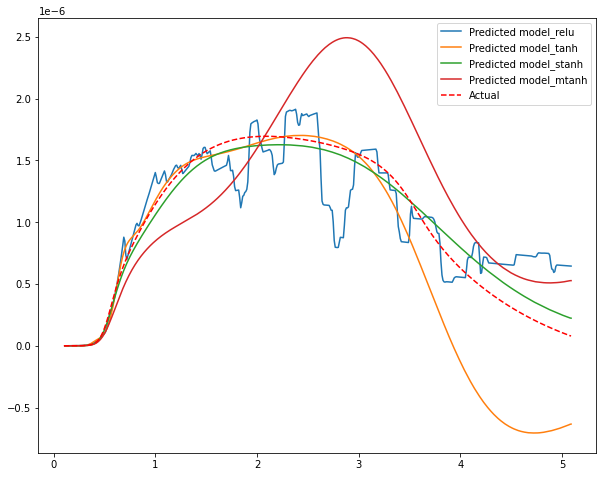

In [ ]:
df1 = pd.read_csv('mosfet_val_9.csv')
xval, yval, df_ = process_data(df1)

fig, ax = plt.subplots(figsize=(10, 8))

show_pred_grad(model_relu, xval, df1, 'Vgs',  'model_relu')
show_pred_grad(model_tanh, xval, df1, 'Vgs', 'model_tanh')
# show_pred_grad(model_srelu, xval, df1, 'Vgs', 'model_srelu')
show_pred_grad(model_stanh, xval, df1, 'Vgs', 'model_stanh')
show_pred_grad(model_mtanh, xval, df1, 'Vgs', 'model_mtanh')
# show_val_grad(xval, yval, df1)
plt.plot(df1['Vgs'], np.gradient(df1['Id']), 'r--', label='Actual')
plt.legend()

Посчитаем MSE для валиадционных данных внутри области обчения

(аккуратнее с переполнением)

In [ ]:
df_val = pd.read_csv('data_val_in.csv')
# df_val = pd.read_csv('mosfet_simple.csv')

In [ ]:
df_val.shape

(556875, 6)

In [ ]:
Xval, yval = data.transform(df_val)

In [ ]:
def print_loss(yval, y_pred):
  loss = keras.losses.MSE(yval, y_pred)
  print('max loss: ', np.max(loss))
  loss_mean = tf.reduce_mean(loss) # Рассчитать среднеквадратичную ошибку партии
  print('mean post-prox loss: ', loss_mean)

In [ ]:
y_pred = model_1.predict(Xval)
y_1 = data.retransform_y(yval)
y_2 = data.retransform_y(y_pred)
print_loss(y_1, y_2)

max loss:  5.752680921360905e-07
mean post-prox loss:  tf.Tensor(3.937789025993993e-09, shape=(), dtype=float64)


In [ ]:
y_pred = model_2.predict(Xval)
y_1 = data.retransform_y(yval)
y_2 = data.retransform_y(y_pred)
print_loss(y_1, y_2)

max loss:  5.75265481759336e-07
mean post-prox loss:  tf.Tensor(4.968530552609526e-09, shape=(), dtype=float64)


In [ ]:
y_pred = model_3.predict(Xval)
y_1 = data.retransform_y(yval)
y_2 = data.retransform_y(y_pred)
print_loss(y_1, y_2)

max loss:  5.7526424908037e-07
mean post-prox loss:  tf.Tensor(3.7913474923305375e-09, shape=(), dtype=float64)


In [ ]:
y_pred = model_4.predict(Xval)
y_1 = data.retransform_y(yval)
y_2 = data.retransform_y(y_pred)
print_loss(y_1, y_2)

max loss:  5.752635239747805e-07
mean post-prox loss:  tf.Tensor(3.777850537832754e-09, shape=(), dtype=float64)


Посчитаем MSE на данных, которые находятся вне области обучения



In [ ]:
df_val_out = pd.read_csv('data_val_out.csv')

In [ ]:
df_val_out.describe()

,Vds,Vgs,L,W,T,Id
count,302580.000000,302580.000000,3.025800e+05,3.025800e+05,302580.000000,3.025800e+05
mean,3.000000,3.000000,9.500000e-07,9.500000e-07,50.000000,4.459659e-04
std,1.774827,1.774827,5.123484e-07,5.123484e-07,35.355397,5.479167e-04
min,0.000000,0.000000,2.000000e-07,2.000000e-07,0.000000,-1.046136e-18
25%,1.500000,1.500000,5.000000e-07,5.000000e-07,25.000000,5.231339e-05
50%,3.000000,3.000000,9.500000e-07,9.500000e-07,50.000000,2.471728e-04
75%,4.500000,4.500000,1.400000e-06,1.400000e-06,75.000000,6.370231e-04
max,6.000000,6.000000,1.700000e-06,1.700000e-06,100.000000,3.978165e-03


Посмотрим на область напряжений

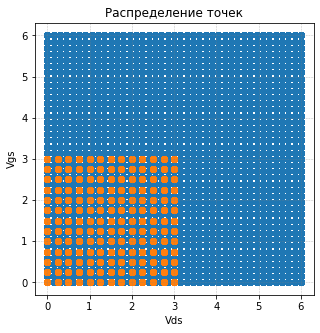

In [ ]:
x = df[df['T'] == df.iloc[0]['T']]['Vds']
y = df[df['T'] == df.iloc[0]['T']]['Vgs']

x_val = df_val_out[df_val_out['T'] == df_val_out.iloc[0]['T']]['Vds']
y_val = df_val_out[df_val_out['T'] == df_val_out.iloc[0]['T']]['Vgs']

fig, ax = plt.subplots(figsize=(5, 5))
ax.set(xlabel='Vds', ylabel='Vgs', title='Распределение точек')
ax.grid(color='gray', alpha=0.5, linestyle='dashed', linewidth=0.5)

# plt.scatter(x, y)
plt.scatter(x_val, y_val)
plt.scatter(x, y)
plt.show()

Посмотрим на область технических параметров

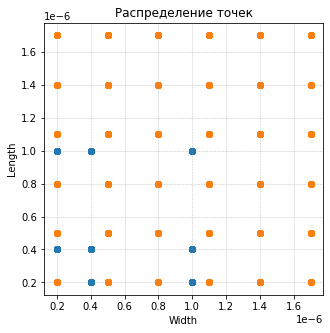

In [ ]:
x = df[df['T'] == df.iloc[0]['T']]['W']
y = df[df['T'] == df.iloc[0]['T']]['L']

x_val = df_val_out[df_val_out['T'] == df_val_out.iloc[0]['T']]['W']
y_val = df_val_out[df_val_out['T'] == df_val_out.iloc[0]['T']]['L']

fig, ax = plt.subplots(figsize=(5, 5))
ax.set(xlabel='Width', ylabel='Length', title='Распределение точек')
ax.grid(color='gray', alpha=0.5, linestyle='dashed', linewidth=0.5)

plt.scatter(x, y)
plt.scatter(x_val, y_val)
plt.show()

Вновь посчитаем сред квадр ошибку, но только теперь для внешней области

In [ ]:
Xval_out, yval_out = data.transform(df_val_out)

In [ ]:
y_pred = model_1.predict(Xval_out)
y_1 = data.retransform_y(yval_out)
y_2 = data.retransform_y(y_pred)
print_loss(y_1, y_2)

max loss:  1.2986552641617138e-05
mean post-prox loss:  tf.Tensor(2.9088336408776717e-07, shape=(), dtype=float64)


In [ ]:
y_pred = model_2.predict(Xval_out)
y_1 = data.retransform_y(yval_out)
y_2 = data.retransform_y(y_pred)
print_loss(y_1, y_2)

max loss:  1.2996641538230282e-05
mean post-prox loss:  tf.Tensor(2.83370642011605e-07, shape=(), dtype=float64)


In [ ]:
y_pred = model_3.predict(Xval_out)
y_1 = data.retransform_y(yval_out)
y_2 = data.retransform_y(y_pred)
print_loss(y_1, y_2)

max loss:  1.2986205040110801e-05
mean post-prox loss:  tf.Tensor(2.579063159860596e-07, shape=(), dtype=float64)


In [ ]:
y_pred = model_4.predict(Xval_out)
y_1 = data.retransform_y(yval_out)
y_2 = data.retransform_y(y_pred)
print_loss(y_1, y_2)

max loss:  1.2986200216894509e-05
mean post-prox loss:  tf.Tensor(2.579094953826248e-07, shape=(), dtype=float64)
